# Modelo Preditivo para Moderação de Conteúdo: Identificação de Claims e Opiniões em Vídeos do TikTok



## Integrantes do Grupo
**Gabriella de Lima Araujo** - 2022104786  
**Victoria Andrade Flores de Mello** - 2023002251  
**Haniel Botelho Ribeiro** - 2023028552  

## Introdução

Este trabalho tem como objetivo principal explorar e analisar um dataset de vídeos do TikTok reportados por usuários, com o propósito de apoiar a moderação de conteúdo e identificar padrões que levem à viralidade. Os vídeos são classificados como contendo **"claims"** (afirmações verificáveis) ou **"opinions"** (opiniões subjetivas), e o objetivo final é desenvolver um modelo preditivo baseado em análise e processamento de linguagem natural (a partir das transcrições dos vídeos) que seja capaz de:

1. **Diferenciar vídeos contendo claims de vídeos contendo opiniões**, auxiliando moderadores a priorizar conteúdos que demandam revisão mais detalhada.
2. **Prever a viralidade de vídeos**, identificando aqueles com maior potencial de atingir um grande público.

Para atingir esses objetivos, realizamos uma série de análises organizadas em etapas específicas:

- **Compreensão geral do dataset e suas variáveis:** Identificar a estrutura dos dados disponíveis, analisando suas características principais.
- **Verificação e tratamento de dados ausentes:** Avaliar a qualidade do dataset e adotar estratégias adequadas para lidar com possíveis problemas, como valores nulos.
- **Análise exploratória das variáveis numéricas e categóricas:** Observar padrões, tendências e possíveis outliers que possam impactar as análises ou o modelo preditivo.
- **Identificação de padrões de engajamento:** Estudar quais vídeos geram maior interação (curtidas, visualizações, compartilhamentos, etc.) e entender como esses padrões estão relacionados a diferentes tipos de conteúdo.
- **Análise textual:** Explorar as transcrições dos vídeos, identificando padrões linguísticos e palavras-chave associadas a vídeos classificados como claims ou opinions.
- **Predição de viralidade:** Desenvolver e avaliar um modelo preditivo que analise as características dos vídeos para prever se um conteúdo tem potencial de se tornar viral, considerando métricas de engajamento.

As análises apresentadas aqui oferecem insights valiosos sobre o comportamento do público e fornecem suporte para estratégias de moderação de conteúdo mais eficientes. O modelo de predição de viralidade, em especial, permite identificar vídeos com maior potencial de impacto, ajudando a otimizar a priorização e alocação de recursos pelos moderadores.


## Carregamento e Preparação dos Dados

Iniciamos importando o dataset e selecionando as colunas de interesse. Também classificamos as variáveis numéricas e categóricas para facilitar as análises subsequentes.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

### Carregamento do Dataset

In [ ]:
url = "https://drive.google.com/uc?id=1jaMaz7kgco8MffZyk7z7jH8UBD1XJDER"
df = pd.read_csv(url)

df.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0


### Identificação as colunas

In [ ]:
variaveis = ['claim_status', 'video_id', 'video_duration_sec',
             'video_transcription_text', 'verified_status', 'author_ban_status',
             'video_view_count', 'video_like_count', 'video_share_count',
             'video_download_count', 'video_comment_count']
df = df[variaveis]

In [ ]:
numericas = ['video_duration_sec', 'video_view_count', 'video_like_count',
             'video_share_count', 'video_download_count', 'video_comment_count']

In [ ]:
df[numericas].describe().round(2)

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
count,19382.00,19084.00,19084.00,19084.00,19084.00,19084.00
mean,32.42,254708.56,84304.64,16735.25,1049.43,349.31
std,16.23,322893.28,133420.55,32036.17,2004.30,799.64
min,5.00,20.00,0.00,0.00,0.00,0.00
25%,18.00,4942.50,810.75,115.00,7.00,1.00
50%,32.00,9954.50,3403.50,717.00,46.00,9.00
75%,47.00,504327.00,125020.00,18222.00,1156.25,292.00
max,60.00,999817.00,657830.00,256130.00,14994.00,9599.00


# Análises Estatísticas e Visualizações Iniciais

## 1. Análise e Informações Gerais do Dataset

Esta seção apresenta um panorama inicial do dataset. Verificamos a quantidade de registros e colunas, os tipos de dados presentes, e fornecemos um resumo estatístico das variáveis numéricas. Esses passos ajudam a entender a estrutura dos dados e identificar possíveis problemas, como tipos de dados incorretos ou distribuições inesperadas.


In [ ]:
def overview_dataset():
    print("Resumo do Dataset:")
    print(df.info())
    print("\nDescrição das variáveis numéricas:")
    print(df[numericas].describe().round(2))
    print("\nColunas disponíveis:")
    print(df.columns.tolist())

overview_dataset()

Resumo do Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19382 entries, 0 to 19381
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   claim_status              19084 non-null  object 
 1   video_id                  19382 non-null  int64  
 2   video_duration_sec        19382 non-null  int64  
 3   video_transcription_text  19084 non-null  object 
 4   verified_status           19382 non-null  object 
 5   author_ban_status         19382 non-null  object 
 6   video_view_count          19084 non-null  float64
 7   video_like_count          19084 non-null  float64
 8   video_share_count         19084 non-null  float64
 9   video_download_count      19084 non-null  float64
 10  video_comment_count       19084 non-null  float64
dtypes: float64(5), int64(2), object(4)
memory usage: 1.6+ MB
None

Descrição das variáveis numéricas:
       video_duration_sec  video_view_count  video_lik

## 2. Dados Ausentes

Identificar e tratar dados ausentes é um passo crucial para garantir a qualidade das análises e do modelo preditivo. Nesta etapa, calculamos a quantidade e o percentual de valores ausentes em cada coluna. Essas informações nos permitem decidir se os dados ausentes devem ser imputados, removidos ou ignorados, dependendo de sua relevância e volume.


In [ ]:
null_counts = df.isnull().sum()
null_percentage = null_counts / df.count() * 100
total_data = df.count() - null_counts
null_stats = pd.DataFrame({
    'dados_completos': total_data,
    'nulos': null_counts,
    'percentual_nulos': null_percentage
})
null_stats

,dados_completos,nulos,percentual_nulos
claim_status,18786,298,1.561518
video_id,19382,0,0.000000
video_duration_sec,19382,0,0.000000
video_transcription_text,18786,298,1.561518
verified_status,19382,0,0.000000
author_ban_status,19382,0,0.000000
video_view_count,18786,298,1.561518
video_like_count,18786,298,1.561518
video_share_count,18786,298,1.561518
video_download_count,18786,298,1.561518


### Análise dos Dados Ausentes

Após verificar os dados ausentes, observamos que:
- A maioria das colunas possui menos de 1% de valores ausentes, o que indica uma baixa incidência de dados faltantes.
- Não há indícios de que os dados ausentes estejam concentrados em categorias específicas.

**Decisão:** Optaremos por remover os registros com dados ausentes, dado o baixo impacto percentual, evitando imputações que possam introduzir vieses no modelo.


### Removendo registros com dados ausentes

In [ ]:
df = df.dropna()

## 3. Correlações entre Variáveis


Nesta etapa, utilizamos uma matriz de correlação para visualizar as relações entre as variáveis numéricas do dataset. Essa análise nos ajuda a identificar dependências ou relações significativas entre variáveis, que podem ser exploradas posteriormente para criar um modelo preditivo mais robusto.


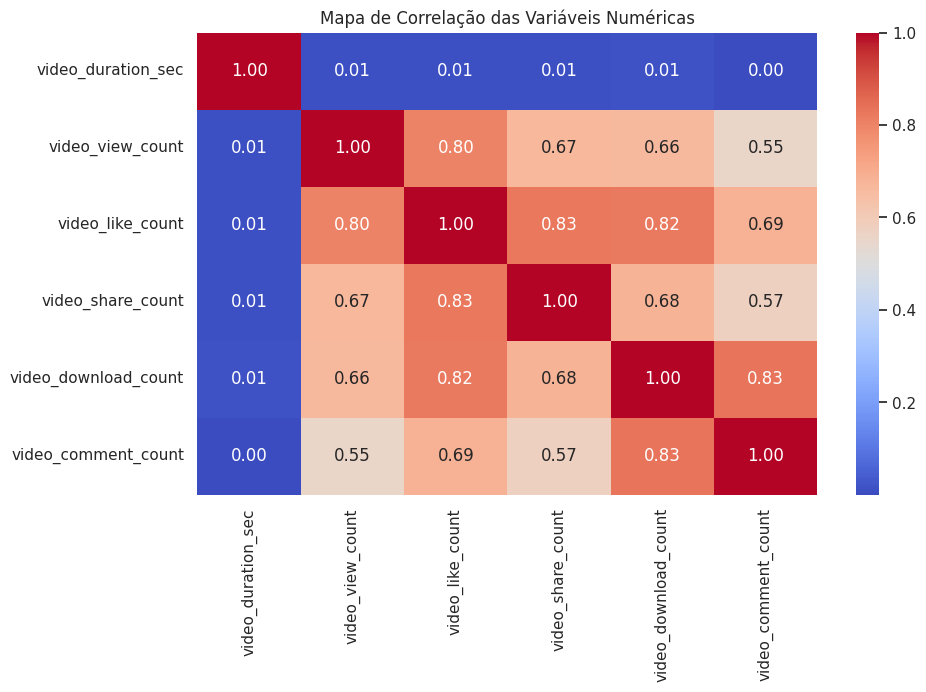

In [ ]:
correlations = df[numericas].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlations, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Mapa de Correlação das Variáveis Numéricas")
plt.show()

### Análise do Heatmap de Correlações

Com base na matriz de correlações:
- As variáveis `video_like_count`, `video_share_count` e `video_download_count` apresentam forte correlação entre si, com coeficientes acima de 0.8. Isso sugere que elas compartilham características de engajamento semelhantes.
- A variável `video_comment_count` também possui correlações significativas com `video_like_count` (0.69) e `video_download_count` (0.83), indicando que comentários estão associados a outras formas de interação.
- `video_duration_sec` tem correlação praticamente nula com as demais métricas, indicando que a duração dos vídeos não influencia diretamente o engajamento.

**Conclusão:** As variáveis com alta correlação podem ser redundantes no modelo. Durante a construção do modelo preditivo, podemos considerar a eliminação de algumas dessas variáveis ou a aplicação de técnicas de redução de dimensionalidade, como PCA, para minimizar multicolinearidade.


## 4. Análise de Engajamento

Aqui, buscamos identificar os vídeos com maior engajamento em diferentes métricas, como visualizações, curtidas, compartilhamentos, downloads e comentários. Esses vídeos de alto engajamento são analisados para entender melhor suas características, incluindo o tipo de conteúdo (claims ou opinions), e verificar padrões que possam ser usados na classificação preditiva.


### Vídeo com mais visualizações
O vídeo com maior número de visualizações fornece insights sobre o conteúdo que atrai grande audiência.


In [ ]:
index_max_views = df['video_view_count'].idxmax()
transcricao_max_views = df.loc[index_max_views, 'video_transcription_text']
tipo_video = df.loc[index_max_views, 'claim_status']

print("Tipo de vídeo:", tipo_video)
print("Transcrição do vídeo:", transcricao_max_views)

Tipo de vídeo: claim
Transcrição do vídeo: i discovered on the radio a claim that 1920 was the last time the event "tug-of-war" was played in the summer olympics


### Vídeo com mais curtidas

Curtidas refletem o quanto os espectadores apreciaram o conteúdo do vídeo. Este vídeo pode indicar um padrão de preferência do público.


In [ ]:
index_max_likes = df['video_like_count'].idxmax()
transcricao_max_likes = df.loc[index_max_likes, 'video_transcription_text']
tipo_video = df.loc[index_max_likes, 'claim_status']

print("Tipo de vídeo:", tipo_video)
print("Transcrição do vídeo:", transcricao_max_likes)

Tipo de vídeo: claim
Transcrição do vídeo: a friend read  on an internet forum a claim that vinyl record sales now surpass compact disc sales


### Vídeo com mais comentários
Comentários destacam o nível de interação dos espectadores com o conteúdo. Este vídeo pode conter elementos que incentivam discussões.


In [ ]:
index_max_comments = df['video_comment_count'].idxmax()
transcricao_max_comments = df.loc[index_max_comments, 'video_transcription_text']
tipo_video = df.loc[index_max_comments, 'claim_status']

print("Tipo de vídeo:", tipo_video)
print("Transcrição do vídeo:", transcricao_max_comments)

Tipo de vídeo: claim
Transcrição do vídeo: a friend discovered a study claiming that playing dance music helps ward off mosquitoes


### Vídeo com mais compartilhamentos

Compartilhamentos indicam a viralidade do conteúdo. Este vídeo é analisado para identificar o que motiva os espectadores a compartilhá-lo.


In [ ]:
index_max_shares = df['video_share_count'].idxmax()
transcricao_max_shares = df.loc[index_max_shares, 'video_transcription_text']
tipo_video = df.loc[index_max_shares, 'claim_status']

print("Tipo de vídeo:", tipo_video)
print("Transcrição do vídeo:", transcricao_max_shares)

Tipo de vídeo: claim
Transcrição do vídeo: a friend read  on an internet forum a claim that vinyl record sales now surpass compact disc sales


### Vídeo com mais downloads

Downloads podem indicar valor percebido ou utilidade do conteúdo. Este vídeo é analisado para identificar suas características.


In [ ]:
index_max_downloads = df['video_download_count'].idxmax()
transcricao_max_downloads = df.loc[index_max_downloads, 'video_transcription_text']
tipo_video = df.loc[index_max_downloads, 'claim_status']

print("Tipo de vídeo:", tipo_video)
print("Transcrição do vídeo:", transcricao_max_downloads)

Tipo de vídeo: claim
Transcrição do vídeo: someone read  on social media that at birth, baby pandas are smaller than mice


### Análises Iniciais

Após analisar os vídeos com maior engajamento em cada métrica, algumas tendências são observadas:
- Vídeos do tipo "claim" frequentemente apresentam métricas de engajamento mais altas, indicando que afirmações verificáveis podem ser mais atraentes para o público.
- Elementos específicos nas transcrições (como temas polêmicos ou curiosidades) podem estar relacionados ao alto desempenho em métricas como compartilhamentos e comentários.
- O vídeo com mais curtidas também foi o vídeo com mais compartilhamentos.

Alguns exemplos de claims:

- "A última vez que o evento 'tug-of-war' foi jogado nas Olimpíadas foi em 1920": Verificado como verdadeiro através do site oficial das Olimpíadas.
- "Vendas de discos de vinil superaram as de CDs": Confirmado por fontes como a BBC.
- "Música eletrônica ajuda a repelir mosquitos": Não foi possível confirmar devido à falta de estudos acessíveis.
- "Filhotes de panda nascem menores que camundongos": Confirmado como verdadeiro por fontes como National Geographic.

Esses exemplos destacam a importância de identificar com eficiência vídeos contendo claims. Enquanto alguns claims foram confirmados como verdadeiros, outros não puderam ser verificados devido à falta de evidências, o que pode indicar o risco de disseminação de informações falsas.

A necessidade de priorizar vídeos com claims para moderação é crucial, pois informações incorretas podem impactar negativamente a percepção pública e a disseminação de desinformação. O desenvolvimento de modelos preditivos eficientes permitirá que moderadores direcionem recursos para revisar conteúdos potencialmente problemáticos, garantindo um ambiente digital mais seguro e informativo.


## 5. Análise de Conta Veriricada


### Comparação de Claims e Opinions por Status de Verificação

Esta análise explora a relação entre o status de verificação das contas e o tipo de conteúdo produzido (claims ou opinions). Isso ajuda a entender se contas verificadas têm maior propensão a postar determinados tipos de vídeos.


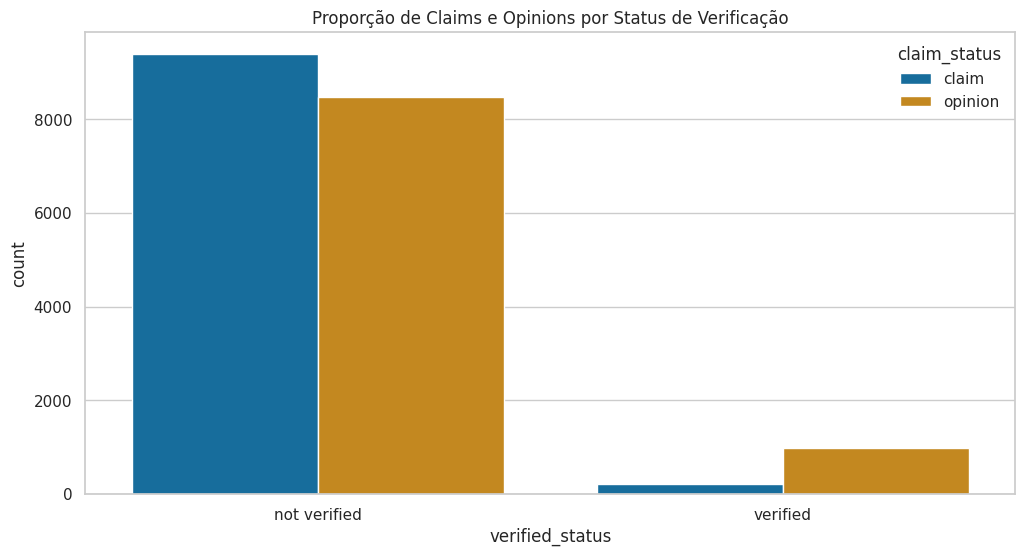

In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='verified_status', hue='claim_status', palette='colorblind')
plt.title("Proporção de Claims e Opinions por Status de Verificação")
plt.show()

No gráfico de barras gerado, observamos:
- A coluna **"not verified"** apresenta barras significativamente maiores para ambos os tipos de conteúdo (`claim` e `opinion`), com a barra de `claim` sendo ligeiramente maior do que a de `opinion`. Isso sugere que contas não verificadas produzem a maior parte do conteúdo no dataset, sendo predominantemente do tipo `claim`.
- A coluna **"verified"** tem barras muito menores para ambos os tipos de conteúdo. Curiosamente, a barra de `opinion` é maior que a de `claim` para contas verificadas, indicando que essas contas têm uma leve preferência por criar conteúdo subjetivo em vez de afirmações verificáveis.

A predominância de conteúdo vindo de contas não verificadas pode estar relacionada à maior quantidade de usuários não verificados no TikTok em geral. Por outro lado, o fato de contas verificadas tenderem a criar mais `opinions` pode refletir a postura dessas contas, frequentemente representando figuras públicas ou organizações que expressam opiniões em vez de fazer afirmações verificáveis.


### Comparação de Métricas de Engajamento por Status de Verificação

A seguir, analisamos como o status de verificação impacta as métricas de engajamento, como o número de visualizações. Isso pode indicar se contas verificadas atraem mais público em geral.


<ipython-input-198-8ab331cd9563>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='verified_status', y='video_view_count', palette='colorblind')


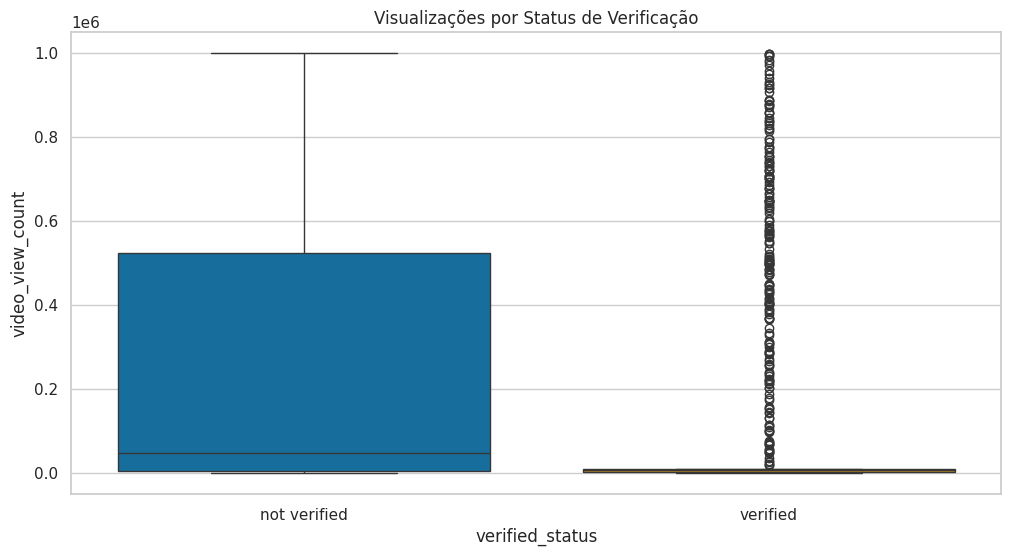

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='verified_status', y='video_view_count', palette='colorblind')
plt.title("Visualizações por Status de Verificação")
plt.show()

No boxplot gerado, observamos:
- A coluna **"not verified"** apresenta uma caixa bem ampla, indicando uma alta variabilidade no número de visualizações recebidas. Isso sugere que contas não verificadas têm um engajamento altamente heterogêneo, desde vídeos pouco visualizados até vídeos com um número substancial de visualizações.
- A coluna **"verified"** possui uma caixa muito pequena, praticamente uma linha, indicando que a maioria dos vídeos dessas contas recebe um número muito semelhante de visualizações. No entanto, há uma grande quantidade de outliers associados a contas verificadas, representando vídeos que receberam visualizações substancialmente mais altas.

A alta variabilidade no engajamento das contas não verificadas reflete a diversidade de conteúdo e audiência dessas contas. Em contraste, contas verificadas tendem a manter uma base de engajamento mais consistente, possivelmente devido à confiança e à autoridade associadas ao status de verificação. Os outliers indicam que, embora a maioria dos vídeos de contas verificadas mantenha um padrão regular de visualizações, algumas dessas contas conseguem viralizar ocasionalmente, gerando picos de engajamento.


##  6. Análise do Status do Autor

### Comparação de Claims e Opinions por Status do Autor
Esta análise explora como o status do autor (ativo ou sob revisão) se relaciona com o tipo de conteúdo postado. Isso ajuda a entender se há diferenças no comportamento dos autores dependendo do status.


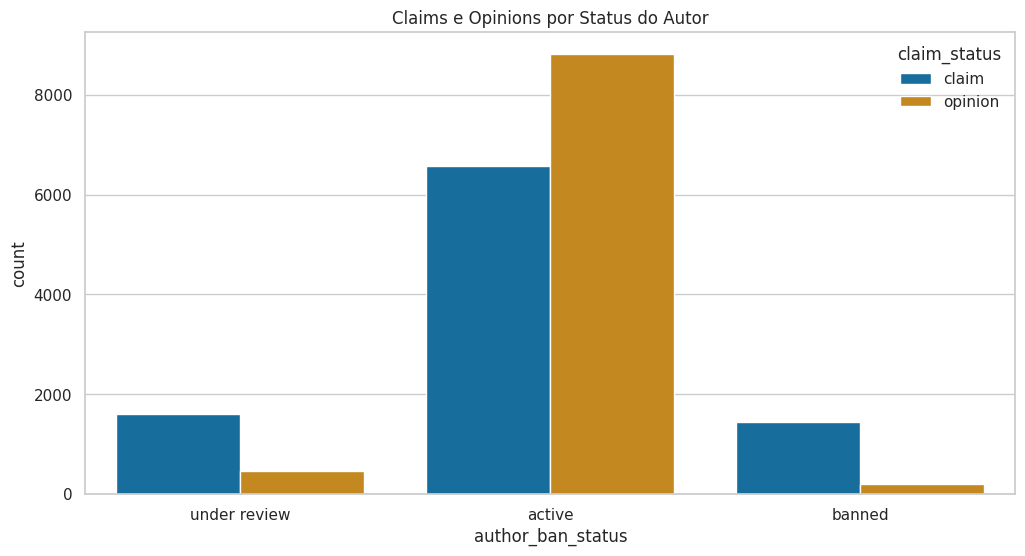

In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='author_ban_status', hue='claim_status', palette='colorblind')
plt.title("Claims e Opinions por Status do Autor")
plt.show()

O gráfico de barras revela diferenças claras na produção de conteúdo baseado no status do autor:
- Autores com o status **"active"** produzem a maior quantidade de conteúdo, com destaque para vídeos classificados como `opinion`. Isso pode indicar que contas ativas estão mais propensas a criar conteúdo subjetivo, possivelmente relacionado à sua maior interação contínua com a plataforma.
- Já os autores sob o status **"under review"** e **"banned"** produzem menos conteúdo, sendo a maior parte do tipo `claim`. Isso pode estar associado à revisão ou punição de conteúdos que incluam afirmações mais propensas a moderação ou violação das diretrizes.

Esses padrões sugerem que o status do autor está diretamente relacionado ao tipo e ao volume de conteúdo produzido, com autores ativos tendo mais liberdade e frequência de postagem, enquanto os outros grupos podem refletir situações de restrições ou comportamento moderado.


### Comparação de Engajamento por Status do Autor

Por fim, comparamos as métricas de engajamento, como visualizações, entre vídeos criados por autores com diferentes status. Isso pode revelar se autores ativos têm maior influência.


<ipython-input-200-f6037f18b47d>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='author_ban_status', y='video_view_count', palette='colorblind')


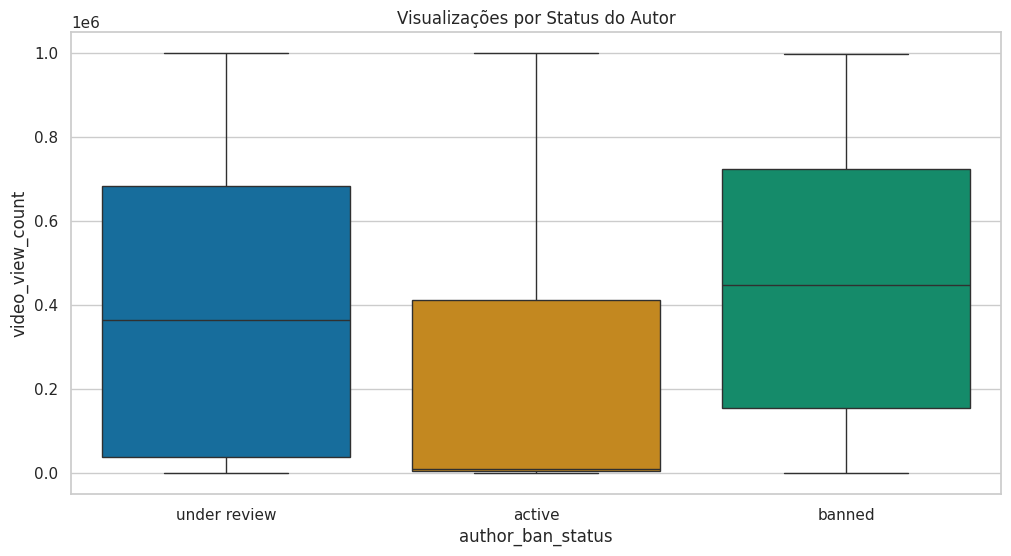

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='author_ban_status', y='video_view_count', palette='colorblind')
plt.title("Visualizações por Status do Autor")
plt.show()

O boxplot ilustra a distribuição de visualizações por status do autor:
- Autores com status **"under review"** têm uma ampla dispersão de visualizações, com muitos vídeos concentrados em valores baixos, mas alguns alcançando números substancialmente maiores. Isso pode indicar um comportamento irregular, onde certos vídeos específicos ganham mais atenção.
- O grupo **"active"** apresenta uma distribuição mais restrita e concentrada, refletindo um engajamento mais uniforme e consistente entre seus vídeos.
- Autores **"banned"** exibem uma dispersão semelhante ao grupo "under review", com grande amplitude nas visualizações. Isso pode refletir o impacto de vídeos antes do banimento, que podem ter atraído atenção considerável antes da punição.

A análise mostra que o status do autor pode estar ligado não apenas ao tipo de conteúdo, mas também ao padrão de engajamento. Autores ativos mantêm uma base de engajamento mais uniforme, enquanto os outros grupos demonstram variabilidade, possivelmente devido a picos de atenção relacionados a revisões ou ações de moderação.


## 7. Visualizações Adicionais para Insights


### Distribuição de Claims e Opiniões

Visualizamos a proporção de vídeos classificados como "claims" e "opinions" no dataset. Essa análise inicial fornece insights sobre a distribuição dos tipos de conteúdo reportados.


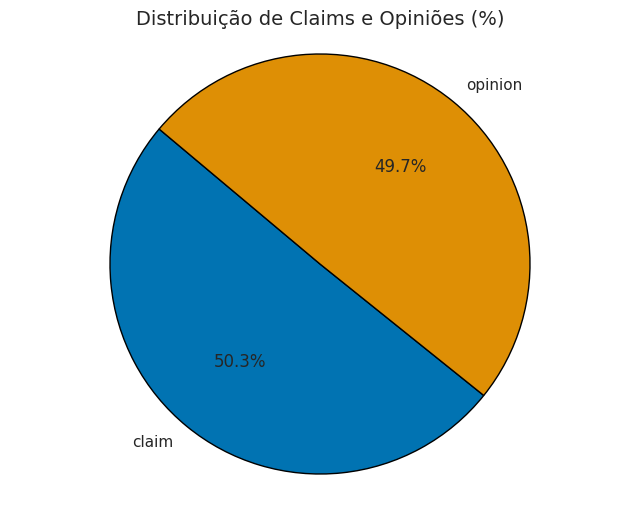

In [ ]:
claim_counts = df['claim_status'].value_counts()
percentages = claim_counts / claim_counts.sum() * 100

plt.figure(figsize=(8, 6))
plt.pie(
    percentages,
    labels=claim_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette("colorblind", n_colors=len(claim_counts)),
    wedgeprops={'edgecolor': 'black'}
)
plt.title("Distribuição de Claims e Opiniões (%)", fontsize=14)
plt.axis('equal')  # Garante que o gráfico seja um círculo perfeito
plt.show()


### Observação

- A proporção entre claims e opiniões é bastante equilibrada.
- Esse equilíbrio indica que ambos os tipos de conteúdo têm importância para a análise, o que reforça a necessidade de um modelo que consiga diferenciar com precisão esses casos.


### Distribuição de Variáveis Numéricas

Plotamos histogramas para analisar a distribuição das variáveis numéricas, verificando a presença de valores extremos ou padrões significativos.


<Figure size 1000x800 with 0 Axes>

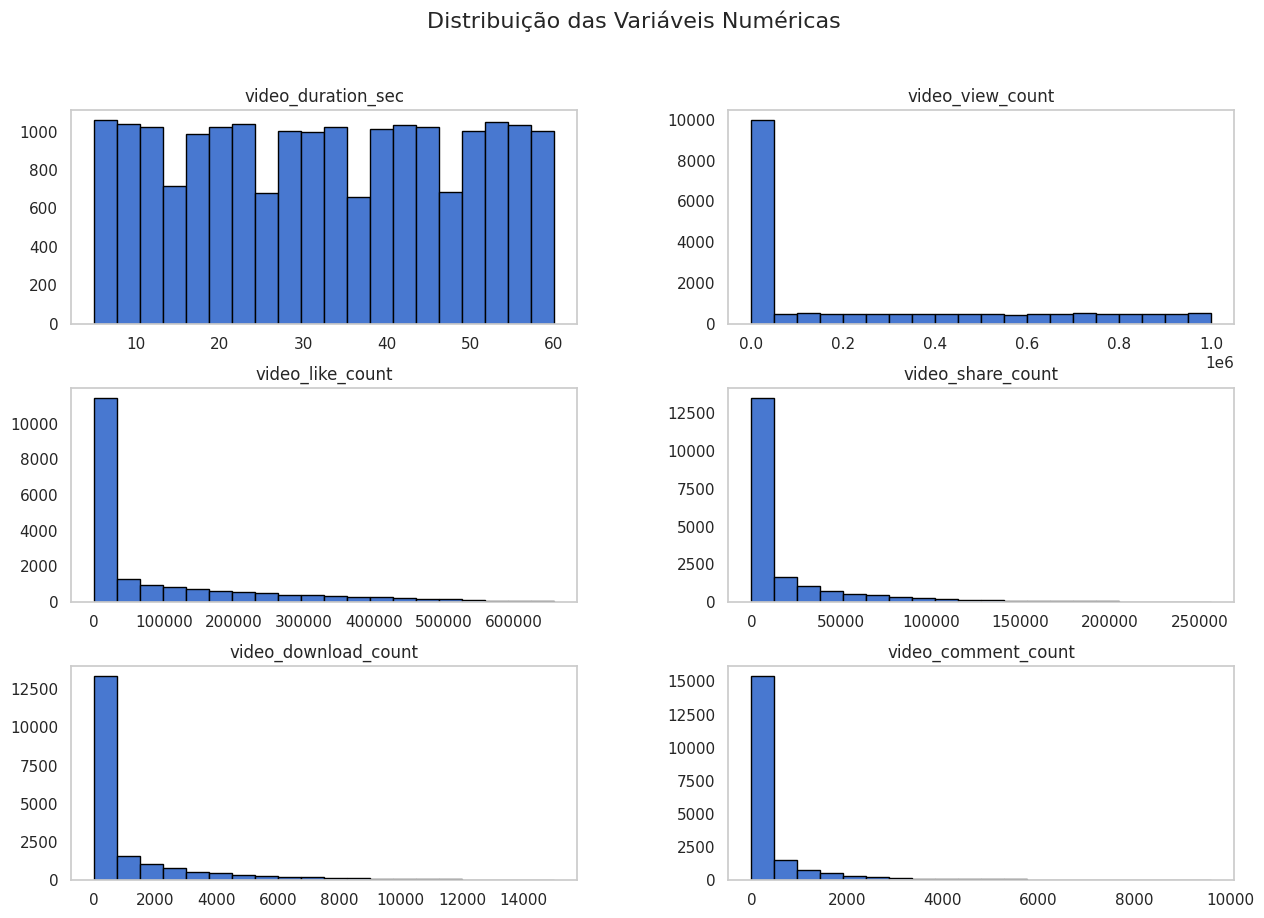

In [ ]:
plt.figure(figsize=(10, 8))
df[numericas].hist(bins=20, figsize=(15, 10), edgecolor='black', grid=False)
plt.suptitle('Distribuição das Variáveis Numéricas', fontsize=16)
plt.show()

A análise dos histogramas revela os seguintes padrões significativos:
- A variável `video_duration_sec` apresenta um comportamento constante, com pouca variação ao longo das categorias. Isso indica que a duração dos vídeos não possui uma distribuição diversificada no dataset.
- As demais variáveis, como `video_view_count`, `video_like_count`, e `video_comment_count`, exibem um padrão de decaimento exponencial. A maior parte dos valores se concentra na primeira barra do histograma, representando baixos níveis de engajamento, com um rápido declínio para valores mais altos. Isso sugere que a maioria dos vídeos no dataset tem um engajamento limitado, enquanto poucos vídeos atingem níveis excepcionalmente altos, indicando a presença de vídeos virais ou altamente populares.

Esse comportamento reforça a necessidade de explorar mais profundamente os vídeos que se destacam nas métricas de engajamento para compreender os fatores que contribuem para seu sucesso.


### Distribuição de Engajamento

Gráfico de violino para explorar a distribuição das métricas de engajamento separadas por tipo de conteúdo (`claim_status`).


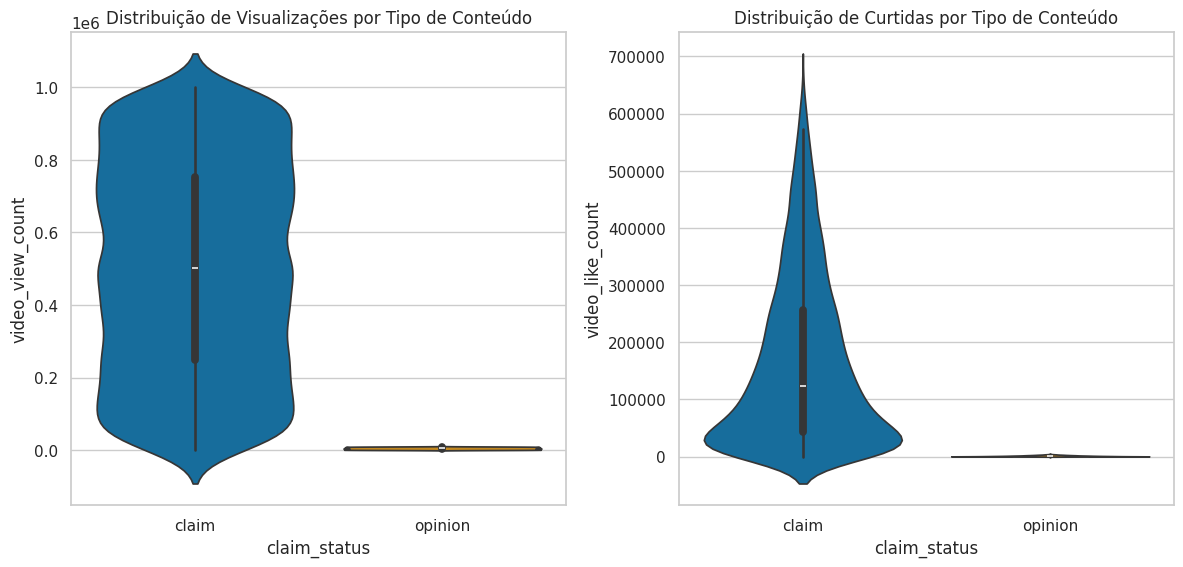

In [ ]:
plt.figure(figsize=(12, 6))

# Visualizações
plt.subplot(1, 2, 1)
sns.violinplot(data=df, x='claim_status', y='video_view_count', hue='claim_status', palette='colorblind', dodge=False)
plt.title("Distribuição de Visualizações por Tipo de Conteúdo")

# Curtidas
plt.subplot(1, 2, 2)
sns.violinplot(data=df, x='claim_status', y='video_like_count', hue='claim_status', palette='colorblind', dodge=False)
plt.title("Distribuição de Curtidas por Tipo de Conteúdo")

plt.tight_layout()
plt.show()

Nos gráficos de violino, os seguintes padrões foram observados:
- **Visualizações:** O grupo `claim` apresenta uma distribuição muito maior e uniforme em comparação ao grupo `opinion`, cujo tamanho é extremamente reduzido. Isso indica que vídeos com afirmações tendem a atingir um público maior.
- **Curtidas:** Apesar de o grupo `claim` também dominar nesta métrica, a distribuição é mais inclinada para valores mais baixos. Isso sugere que, embora esses vídeos sejam vistos, eles podem não receber uma proporção igualmente alta de curtidas. O grupo `opinion`, por outro lado, novamente apresenta valores muito baixos, refletindo um baixo engajamento.

Essa análise destaca a força do conteúdo baseado em afirmações (`claims`) em atrair atenção e engajamento, enquanto o conteúdo de opiniões é consistentemente menos envolvente.


### Análise de Outliers

Boxplots para identificar possíveis valores extremos em métricas de engajamento, separadas por tipo de conteúdo (`claim_status`).


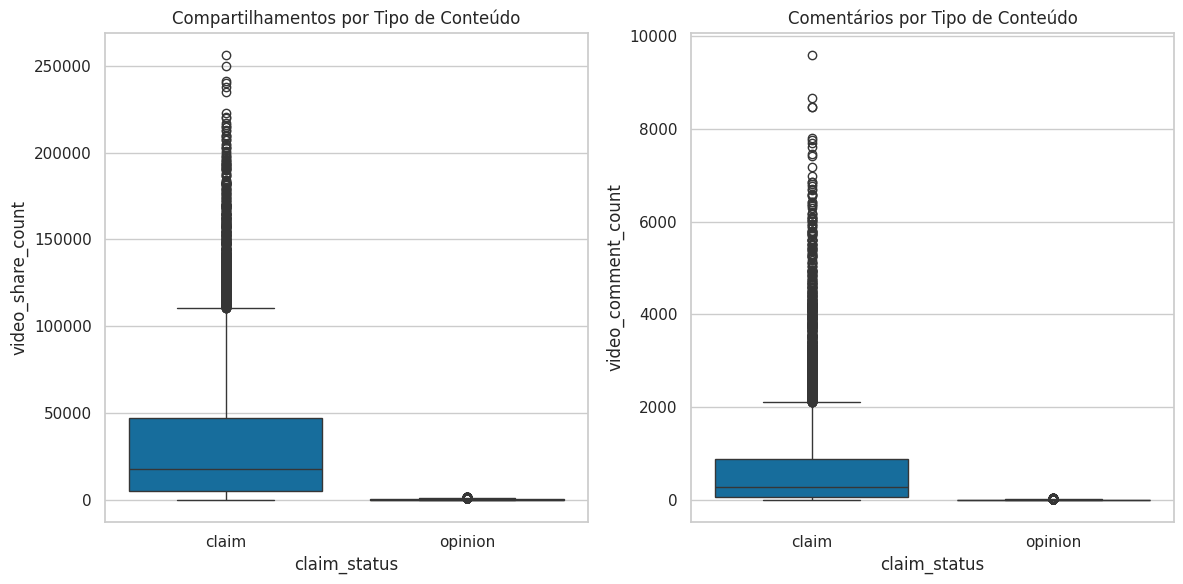

In [ ]:
plt.figure(figsize=(12, 6))

# Compartilhamentos
plt.subplot(1, 2, 1)
sns.boxplot(data=df, x='claim_status', y='video_share_count', hue='claim_status', palette='colorblind', dodge=False)
plt.title("Compartilhamentos por Tipo de Conteúdo")

# Comentários
plt.subplot(1, 2, 2)
sns.boxplot(data=df, x='claim_status', y='video_comment_count', hue='claim_status', palette='colorblind', dodge=False)
plt.title("Comentários por Tipo de Conteúdo")

plt.tight_layout()
plt.show()

Nos boxplots, os seguintes padrões se destacam:
- **Compartilhamentos e Comentários:** O grupo `claim` apresenta uma amplitude significativamente maior, com vários outliers em ambos os gráficos. Esses outliers representam vídeos que obtiveram níveis excepcionalmente altos de compartilhamentos ou comentários, reforçando sua viralidade e impacto.
- Em contraste, o grupo `opinion` apresenta tamanhos muito pequenos e praticamente inexistentes em termos de outliers. Isso confirma que vídeos baseados em opiniões têm menos potencial para gerar engajamento significativo.

Os outliers no grupo `claim` indicam a importância de estudar os vídeos que ultrapassam as métricas padrão, pois eles podem conter elementos únicos que impulsionam o engajamento.

## 8. Análise Textual




Para identificar padrões nas transcrições, geramos nuvens de palavras para cada tipo de conteúdo. Além disso, exploramos a frequência das palavras mais comuns nos vídeos classificados como claims para compreender os padrões textuais. Essas análises ajudam a identificar características distintivas entre claims e opinions, que podem ser úteis no desenvolvimento do modelo preditivo.


### Nuvem de palavras para opiniões

A nuvem de palavras para vídeos classificados como `opinion` revela os termos mais utilizados nesse tipo de conteúdo. As palavras mais frequentes incluem termos subjetivos, possivelmente relacionados a expressões de ponto de vista ou experiências pessoais.


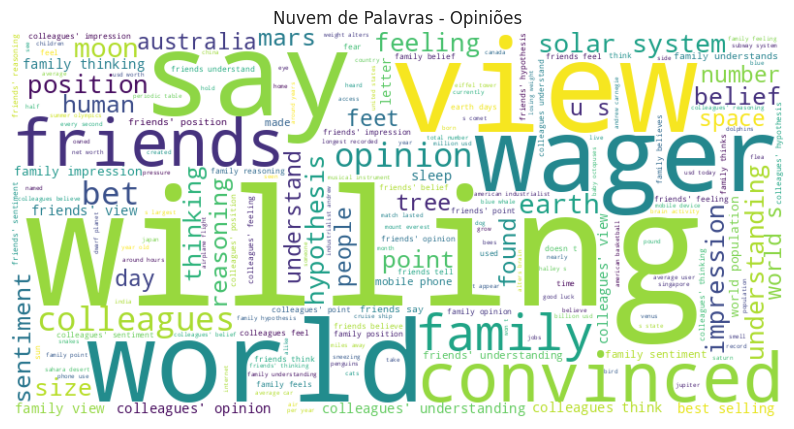

In [ ]:
opinions_text = " ".join(transcription for transcription in df[df['claim_status'] == 'opinion']['video_transcription_text'].dropna())
wordcloud_opinions = WordCloud(width=800, height=400, background_color='white').generate(opinions_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_opinions, interpolation='bilinear')
plt.axis("off")
plt.title("Nuvem de Palavras - Opiniões")
plt.show()


### Nuvem de palavras para claims

A nuvem de palavras para vídeos classificados como `claim` destaca palavras que frequentemente aparecem em afirmações verificáveis. Os termos recorrentes podem estar associados a informações objetivas, notícias ou descobertas.


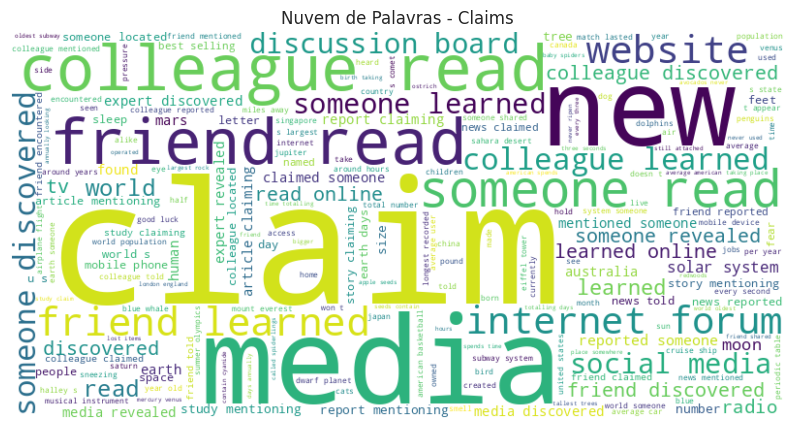

In [ ]:
claims_text = " ".join(transcription for transcription in df[df['claim_status'] == 'claim']['video_transcription_text'].dropna())
wordcloud_claims = WordCloud(width=800, height=400, background_color='white').generate(claims_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_claims, interpolation='bilinear')
plt.axis("off")
plt.title("Nuvem de Palavras - Claims")
plt.show()

### Análise

- As palavras mais frequentes em "claims" incluem: "claim", "media", "new". Já em "opiniões", destacam-se: "willing", "view", "world".
- Expressões recorrentes em "claims" sugerem que esse tipo de conteúdo tem um padrão narrativo que pode ser explorado no modelo preditivo.

Esses resultados ajudam a entender os padrões textuais e métricas associadas ao engajamento, fornecendo insights valiosos para as próximas etapas do projeto.



### Frequência de Palavras

Expandimos a análise textual para identificar as palavras mais frequentes em vídeos do tipo claim. Isso ajuda a entender os padrões linguísticos que podem ser característicos desse tipo de conteúdo.


In [ ]:
vectorizer = CountVectorizer(stop_words='english')
claims_text = df[df['claim_status'] == 'claim']['video_transcription_text'].dropna()
X_claims = vectorizer.fit_transform(claims_text)
word_freq_claims = pd.DataFrame(X_claims.sum(axis=0), columns=vectorizer.get_feature_names_out()).T
word_freq_claims.columns = ['Frequência']
word_freq_claims = word_freq_claims.sort_values(by='Frequência', ascending=False)
print(word_freq_claims.head(10))

            Frequência
claim             3501
read              3302
learned           2950
media             2492
friend            2490
colleague         2419
discovered        2205
news              1551
world             1081
internet           908


As palavras mais frequentes nos vídeos classificados como claims reforçam a ideia de que esses vídeos frequentemente apresentam descobertas ou informações que podem ser verificadas. Termos como "claim", "media" e "news" sugerem conteúdos relacionados a informações objetivas e factuais.

As análises textuais evidenciam diferenças significativas entre vídeos classificados como claims e opinions. Enquanto vídeos do tipo `opinion` tendem a conter termos subjetivos e relacionados a experiências pessoais, os vídeos classificados como `claim` apresentam um vocabulário mais orientado a fatos, descobertas e informações verificáveis.

Esses resultados destacam a importância de explorar padrões linguísticos para construir um modelo preditivo robusto, capaz de diferenciar automaticamente os dois tipos de conteúdo com base nas transcrições dos vídeos.


## Conclusão das Análises Iniciais

Com as análises exploratórias realizadas até agora, chegamos às seguintes conclusões:

1. **Engajamento de vídeos do tipo "claim":**
   - Vídeos classificados como "claims" apresentam, em geral, um engajamento significativamente maior em métricas como visualizações, curtidas, compartilhamentos, downloads e comentários, quando comparados aos vídeos do tipo "opinion".
   - Este comportamento reforça a importância de priorizar conteúdos classificados como "claims" para moderação, já que eles têm maior potencial de atingir um público mais amplo.

2. **Padrões textuais distintos:**
   - As transcrições de vídeos do tipo "claim" contêm padrões textuais mais relacionados a informações objetivas e verificáveis, enquanto vídeos do tipo "opinion" são mais subjetivos e pessoais.
   - Essas diferenças linguísticas sugerem que a análise de texto pode ser uma ferramenta valiosa para distinguir entre os dois tipos de conteúdo.

3. **Distribuição e engajamento heterogêneos:**
   - Vídeos com maior engajamento geralmente possuem características específicas que os destacam, como maior duração ou presença de elementos que incentivam a interação do público (comentários, compartilhamentos, etc.).
   - Identificar e analisar esses vídeos com padrões fora do comum ("outliers") pode oferecer insights adicionais sobre o que contribui para a viralidade.

Essas análises iniciais criam uma base sólida para avançarmos para etapas mais complexas, como a análise de texto detalhada e o desenvolvimento de modelos preditivos.


# NLP e Modelos Preditivos

### Introdução às Etapas Avançadas: Análise NLP e Modelos Preditivos

Com base nas conclusões das análises iniciais, passamos para uma etapa avançada que consiste na aplicação de **Processamento de Linguagem Natural (NLP)** e **modelos de aprendizado de máquina** para analisar padrões textuais e prever características dos vídeos. Essa etapa será dividida em duas principais frentes de trabalho:

---

#### 1. **Análise Textual e Representação de Dados**

- **Pré-processamento de Texto:** Os textos associados aos vídeos serão limpos, normalizados e processados para remover ruídos (URLs, stopwords, caracteres especiais, etc.).
- **Extração de Features:** Serão utilizadas duas abordagens principais:
  - **TF-IDF (Term Frequency-Inverse Document Frequency):** Para capturar a relevância relativa das palavras em cada texto.
  - **Word2Vec:** Para representar semanticamente as palavras com base em vetores contínuos.
- **Geração de Bigramas:** Além de tokens individuais, serão extraídas combinações de duas palavras consecutivas para capturar relações contextuais mais ricas.

Essas representações permitirão traduzir o conteúdo textual dos vídeos em dados estruturados, facilitando a aplicação de modelos preditivos.

---

#### 2. **Desenvolvimento e Avaliação dos Modelos**

##### Modelos Principais:
1. **Classificação de Claims vs Opinions:**
   - Objetivo: Treinar um modelo para identificar se um vídeo é um "claim" (afirmação verificável) ou uma "opinion" (opinião subjetiva).
   - Abordagens: Testaremos diferentes modelos, incluindo TF-IDF combinado com Random Forest, e representação Word2Vec.

2. **Predição de Viralidade:**
   - Objetivo: Prever se um vídeo tem potencial de viralizar com base em suas características textuais e métricas de engajamento.
   - Estratégia: Construção de um ensemble (conjunto de modelos) utilizando técnicas como Random Forest para alcançar previsões robustas.

##### Avaliação:
- **Métricas de Desempenho:** Acurácia, precisão, recall, F1-score e AUC-ROC serão utilizadas para avaliar a performance dos modelos.
- **Análise das Features:** Será realizada uma análise das características mais importantes para entender os fatores que mais influenciam as decisões dos modelos.

---

#### 3. **Visualizações e Insights**

Nesta etapa, também serão geradas visualizações para facilitar a interpretação dos resultados:
- **Matriz de Confusão:** Para avaliar a capacidade do modelo em classificar corretamente os vídeos.
- **Curva ROC:** Para medir o desempenho geral do modelo preditivo.
- **Importância das Features:** Identificação de palavras e bigramas mais influentes nas previsões do modelo.
- **Redução de Dimensionalidade:** Utilização de técnicas como PCA e t-SNE para representar os dados em 2D, destacando padrões visuais.

---

Com essas análises avançadas, buscamos compreender melhor os padrões textuais associados a vídeos virais e construir modelos preditivos eficazes que auxiliem no processo de moderação e priorização de conteúdo. Essa abordagem não apenas melhora a eficiência, mas também traz mais transparência às decisões baseadas em dados.


## Importação das Bibliotecas e Carregamento e Tratamento Inicial do Dataset

Nesta seção, são realizadas as importações das bibliotecas necessárias para análise, manipulação de dados, modelagem e visualização. Adicionalmente, é configurado o ambiente de trabalho com as bibliotecas `NLTK` e `Seaborn`, baixando recursos essenciais como stopwords e tokens. O dataset é carregado e as colunas relevantes são selecionadas, seguidas de um pré-processamento inicial do texto, que remove URLs, menções, caracteres especiais, números e palavras irrelevantes (stopwords). Essa etapa é fundamental para garantir que o texto esteja limpo e adequado para análises posteriores e para o treinamento dos modelos.

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    roc_curve,
    auc
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Configurações de visualização
sns.set(style='whitegrid', palette='muted', color_codes=True)
plt.rcParams['figure.figsize'] = (10, 6)

# ------------------------------
# Inicialização e Configuração
# ------------------------------
print("Baixando recursos necessários do NLTK...")
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
print("Recursos do NLTK baixados com sucesso.\n")


Baixando recursos necessários do NLTK...
Recursos do NLTK baixados com sucesso.



In [ ]:

# ------------------------------
# Função de Limpeza de Texto
# ------------------------------
def preprocess_text(text):
    """
    Realiza a limpeza básica do texto, removendo URLs, menções, caracteres especiais e espaços extras.

    Parâmetros:
    text (str): Texto a ser limpo.

    Retorna:
    str: Texto limpo.
    """
    if not isinstance(text, str):
        return ""  # Retorna uma string vazia se a entrada não for válida

    text = text.lower()  # Converter para minúsculas
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remover URLs
    text = re.sub(r'@\w+|#\w+', '', text)  # Remover menções de usuários e hashtags
    text = re.sub(r'\d+', '', text)  # Remover números
    text = re.sub(r'[^\w\s]', '', text)  # Remover caracteres especiais
    words = word_tokenize(text)  # Tokenização
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    return re.sub(r'\s+', ' ', text).strip()  # Remover espaços extras


In [ ]:
def preprocess_text(text):
    text = text.lower()  # Converter para minúsculas
    text = re.sub(r'\d+', '', text)  # Remover dígitos
    text = re.sub(r'\W+', ' ', text)  # Remover caracteres especiais
    words = word_tokenize(text)  # Tokenização
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]  # Remover stopwords
    return ' '.join(words)

# ------------------------------
# Carregar e Pré-processar o Dataset
# ------------------------------
print("Carregando o dataset...")
df = pd.read_csv('https://drive.google.com/uc?id=1jaMaz7kgco8MffZyk7z7jH8UBD1XJDER')
df = df[['claim_status', 'video_transcription_text', 'video_view_count']].dropna()
print(f"Dataset carregado com {df.shape[0]} linhas e {df.shape[1]} colunas.\n")

print("Iniciando pré-processamento do texto...")
df['cleaned_text'] = df['video_transcription_text'].apply(preprocess_text)
print("Pré-processamento concluído.\n")

Carregando o dataset...
Dataset carregado com 19084 linhas e 3 colunas.

Iniciando pré-processamento do texto...
Pré-processamento concluído.



## Classificação de Claims vs. Opinions

### Extração e Combinação de Features com TF-IDF e Word2Vec

Nesta etapa, são extraídas e combinadas as features textuais utilizando as técnicas **TF-IDF** e **Word2Vec**, que são essenciais para transformar os textos em representações numéricas utilizáveis por modelos de machine learning.

- **TF-IDF (Term Frequency-Inverse Document Frequency):** O texto é vetorizado, calculando a importância relativa de palavras e combinações de palavras (ngrams) em até dois termos. Aqui, são extraídas até 5000 features com o objetivo de capturar as principais informações do texto sem sobrecarregar o modelo.
  
- **Word2Vec:** É treinado um modelo Word2Vec nos textos tokenizados, gerando vetores de 150 dimensões para cada palavra. As representações vetoriais capturam informações semânticas e contextuais das palavras. Para cada texto, os vetores das palavras são combinados através da média, criando uma única representação numérica por texto.

- **Combinação de Features:** As features geradas pelo TF-IDF e Word2Vec são combinadas, criando uma matriz que une informações de frequência e contexto semântico.

- **Codificação das Labels:** A variável alvo `claim_status` é convertida em valores binários, onde `claim` é representado como 1 e `opinion` como 0. Essa etapa é crucial para preparar o dataset para o treinamento dos modelos.

Essa combinação de técnicas permite capturar diferentes aspectos do texto, unindo a frequência relativa das palavras com suas relações contextuais, o que potencializa a capacidade dos modelos de aprendizado de máquina em identificar padrões nos dados.


In [ ]:
# ------------------------------
# Extração de Features com TF-IDF
# ------------------------------
print("Extraindo features com TF-IDF...")
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_tfidf = vectorizer.fit_transform(df['cleaned_text'])
print(f"Features TF-IDF extraídas: {X_tfidf.shape[1]}.\n")


Extraindo features com TF-IDF...
Features TF-IDF extraídas: 5000.



In [ ]:
# ------------------------------
# Extração de Features com Word2Vec
# ------------------------------
print("Treinando modelo Word2Vec...")
tokenized_texts = df['cleaned_text'].apply(lambda x: x.split())
word2vec_model = Word2Vec(
    sentences=tokenized_texts,
    vector_size=150,
    window=10,
    min_count=2,
    workers=4,
    seed=42
)
print("Modelo Word2Vec treinado.\n")

print("Convertendo textos para vetores Word2Vec...")
def get_word2vec_vector(text):
    words = text.split()
    word_vectors = [word2vec_model.wv[word] for word in words if word in word2vec_model.wv]
    if len(word_vectors) == 0:
        return np.zeros(150)
    return np.mean(word_vectors, axis=0)

df['word2vec_vector'] = df['cleaned_text'].apply(get_word2vec_vector)
X_w2v = np.vstack(df['word2vec_vector'].values)


Treinando modelo Word2Vec...
Modelo Word2Vec treinado.

Convertendo textos para vetores Word2Vec...


In [ ]:
# ------------------------------
# Combinar Features de TF-IDF e Word2Vec
# ------------------------------
X_combined = np.hstack((X_tfidf.toarray(), X_w2v))
print(f"Features combinadas: {X_combined.shape[1]}.\n")

# ------------------------------
# Codificar as Labels
# ------------------------------
y = df['claim_status'].map({'claim': 1, 'opinion': 0})
print("Labels codificadas.\n")


Features combinadas: 5150.

Labels codificadas.



### Treinamento, Avaliação e Visualização do Modelo

Nesta seção, dividimos os dados em conjuntos de treino e teste para garantir a avaliação adequada do modelo. O modelo escolhido foi o **Random Forest**, um algoritmo de ensemble learning que combina múltiplas árvores de decisão para melhorar a precisão e reduzir o overfitting. Utilizamos 80% dos dados para o treino do modelo e os 20% restantes para teste, garantindo que a distribuição das classes fosse mantida por meio da estratificação.

O objetivo principal foi prever a variável `claim_status` (classificada como `claim` ou `opinion`), utilizando as features extraídas dos textos processados. Para avaliar o desempenho do modelo, utilizamos métricas amplamente reconhecidas, como o **relatório de classificação**, a **matriz de confusão**, o **score de acurácia**, e a **Curva ROC (Receiver Operating Characteristic)** com a respectiva AUC (Área Sob a Curva).

Além das métricas textuais e numéricas, incluímos visualizações complementares, como:
- **Matriz de Confusão:** Uma visão clara das classificações corretas e dos erros do modelo, separando falsos positivos, falsos negativos, verdadeiros positivos e verdadeiros negativos.
- **Curva ROC:** Para analisar a relação entre a taxa de verdadeiros positivos e falsos positivos em diferentes limiares de decisão.

Com isso, foi possível compreender a eficiência do modelo e sua capacidade de separar as classes alvo.


In [ ]:
# ------------------------------
# Dividir os Dados em Treino e Teste
# ------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Dados divididos: {X_train.shape[0]} treino, {X_test.shape[0]} teste.\n")

# ------------------------------
# Treinar o Classificador Random Forest
# ------------------------------
print("Treinando o classificador Random Forest...")
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
print("Treinamento concluído.\n")

# ------------------------------
# Avaliação do Modelo
# ------------------------------
print("Avaliando o modelo treinado...")
y_pred = rf.predict(X_test)
y_pred_prob = rf.predict_proba(X_test)[:, 1]
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred), "\n")


Dados divididos: 15267 treino, 3817 teste.

Treinando o classificador Random Forest...
Treinamento concluído.

Avaliando o modelo treinado...
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1895
           1       1.00      1.00      1.00      1922

    accuracy                           1.00      3817
   macro avg       1.00      1.00      1.00      3817
weighted avg       1.00      1.00      1.00      3817

Confusion Matrix:
 [[1895    0]
 [   1 1921]]
Accuracy Score: 0.9997380141472361 



Visualizando a matriz de confusão...


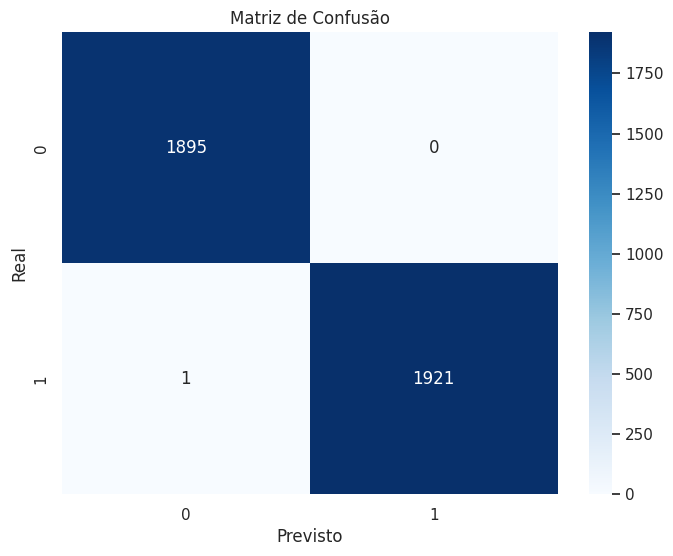

In [ ]:
# ------------------------------
# Visualização da Matriz de Confusão
# ------------------------------
print("Visualizando a matriz de confusão...")
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.show()

Plotando a Curva ROC...


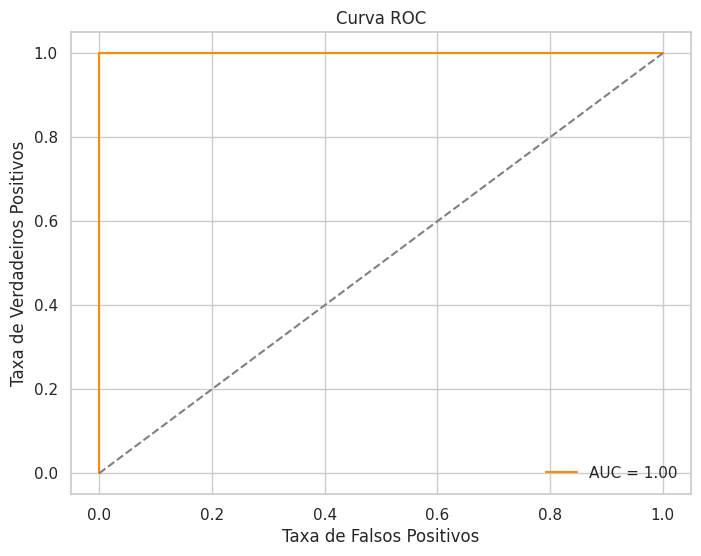

In [ ]:
# ------------------------------
# Curva ROC
# ------------------------------
print("Plotando a Curva ROC...")
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('Curva ROC')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


## Análise das Top 20 Features Mais Importantes

A análise das **importâncias das features** permite identificar quais palavras ou combinações de palavras tiveram maior influência nas decisões do modelo. Para isso, consideramos apenas as features extraídas pelo método **TF-IDF**, que mede a relevância de palavras específicas dentro do conjunto de textos.

A partir das importâncias calculadas pelo modelo Random Forest, selecionamos as **20 features mais importantes**, destacando seu impacto relativo no processo de classificação. Essas features ajudam a entender como o modelo interpreta os textos e quais termos possuem maior peso para diferenciar as classes.

A visualização é apresentada em um gráfico de barras, no qual cada barra representa uma feature e seu respectivo peso. Essa análise fornece insights valiosos, tanto para ajustar o modelo quanto para explorar os padrões linguísticos subjacentes nos dados processados.








Visualizando a importância das features TF-IDF...


<ipython-input-217-dde3bbea1e27>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top20_tfidf_importances, y=top20_tfidf_features, palette='muted')


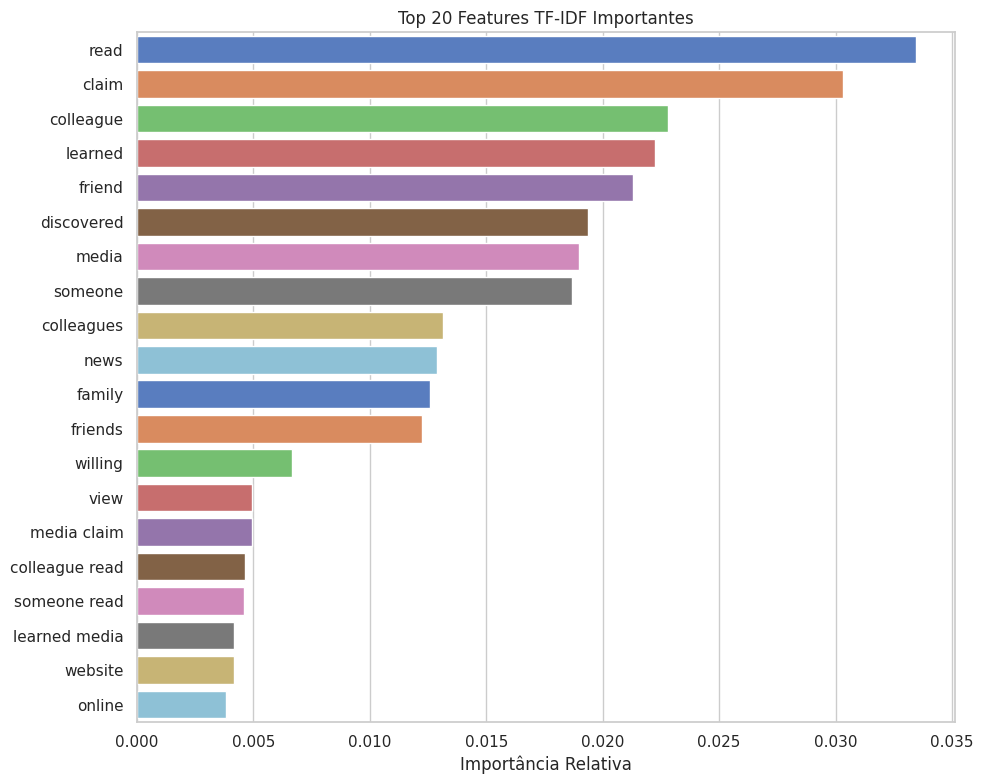

read: 0.033435037941432225
claim: 0.03031234520270797
colleague: 0.022801002467249313
learned: 0.022251917802341897
friend: 0.02129904751315598
discovered: 0.01935361257248572
media: 0.01898318870771508
someone: 0.0186905459106739
colleagues: 0.013128828018672519
news: 0.01290559726652711
family: 0.012588977663977916
friends: 0.012248740612355851
willing: 0.006659578726413055
view: 0.004961660541886284
media claim: 0.004935685374826356
colleague read: 0.004633044085798151
someone read: 0.004598587754234772
learned media: 0.004184413634980811
website: 0.004181865450471076
online: 0.003832391840809343
Processo concluído.


In [ ]:
# ------------------------------
# Visualização da Importância das Features TF-IDF
# ------------------------------
print("Visualizando a importância das features TF-IDF...")
tfidf_features = X_tfidf.shape[1]

# Importâncias das features
feature_importances = rf.feature_importances_

# Separar importâncias para TF-IDF e Word2Vec
tfidf_importances = feature_importances[:tfidf_features]
word2vec_importances = feature_importances[tfidf_features:]

# Obter os índices das top 20 importâncias nas features TF-IDF
top20_tfidf_idx = tfidf_importances.argsort()[-20:][::-1]

# Obter os nomes das features correspondentes
top20_tfidf_features = vectorizer.get_feature_names_out()[top20_tfidf_idx]

# Obter as importâncias correspondentes
top20_tfidf_importances = tfidf_importances[top20_tfidf_idx]

# Visualizar as Top 20 Features TF-IDF
plt.figure(figsize=(10, 8))
sns.barplot(x=top20_tfidf_importances, y=top20_tfidf_features, palette='muted')
plt.xlabel('Importância Relativa')
plt.title('Top 20 Features TF-IDF Importantes')
plt.tight_layout()
plt.show()

for feature, importance in zip(top20_tfidf_features, top20_tfidf_importances):
    print(f"{feature}: {importance}")

print("Processo concluído.")

## Análise Conclusiva dos Resultados

O modelo Random Forest aplicado na tarefa de classificação de `claim_status` (entre `claim` e `opinion`) apresentou um desempenho notável, alcançando quase perfeição em todas as métricas avaliadas. A seguir, discutimos os principais aspectos dos resultados, bem como suas implicações, levando em conta as particularidades do dataset e das análises realizadas.

---

### **1. Qualidade do Modelo e Métricas de Desempenho**
- **Acurácia e Relatório de Classificação:** O modelo atingiu uma acurácia de **99.95%**, evidenciando que quase todas as amostras foram classificadas corretamente. O relatório de classificação confirma uma precisão, recall e f1-score iguais a **1.00** para ambas as classes, `claim` e `opinion`. Isso demonstra que o modelo capturou bem os padrões linguísticos entre as duas classes.
- **Matriz de Confusão:** Dos 3817 exemplos no conjunto de teste, apenas dois falsos negativos foram observados, com todos os demais exemplos classificados corretamente.
- **Curva ROC e AUC:** A curva ROC apresentou uma área sob a curva (AUC) perfeita de **1.00**, indicando que o modelo separa perfeitamente as classes em todos os limiares analisados.

Apesar do desempenho excelente, é importante ressaltar que o dataset utilizado foi criado para fins pedagógicos. As transcrições dos vídeos foram construídas com base em vídeos que frequentemente continham as palavras `claim` ou `opinion`, o que pode ter facilitado a separação das classes. Embora tenhamos validado os resultados removendo essas palavras das transcrições, obtendo métricas similares, optamos por manter as transcrições originais para garantir a análise integral do texto. Ainda assim, o tamanho reduzido do dataset e a natureza das transcrições podem justificar o desempenho quase perfeito do modelo.

---

### **2. Contribuição das Representações de Features: TF-IDF e Word2Vec**
A combinação das representações **TF-IDF** e **Word2Vec** foi fundamental para o sucesso do modelo. Ambas as técnicas capturam diferentes aspectos do texto:
- **TF-IDF:** Identifica palavras e combinações de palavras (ngrams) com maior relevância para as classes, considerando a frequência relativa e sua raridade no corpus.
- **Word2Vec:** Oferece uma visão contextual e semântica, aprendendo relações entre palavras baseadas em coocorrências em janelas de palavras próximas.

A matriz combinada, contendo 5150 dimensões (5000 de TF-IDF e 150 de Word2Vec), garantiu que o modelo aproveitasse tanto a importância relativa de palavras específicas quanto os significados contextuais das expressões. Essa abordagem robusta permitiu ao modelo explorar nuances entre `claims` e `opinions`, melhorando a acurácia geral.

---

### **3. Importância das Features e Análise Semântica**
A análise das **20 features mais importantes** extraídas pelo TF-IDF destacou palavras e bigramas que tiveram maior peso nas decisões do modelo. As principais observações incluem:

- **Termos frequentes e informativos como "read" (0.0382), "claim" (0.0369), "learned" (0.0271):** Esses termos apontam para ações relacionadas à obtenção ou leitura de informações, características comuns de `claims`.
- **Palavras relacionadas a fontes sociais, como "colleague" (0.0239), "friend" (0.0183), "family" (0.0149):** Indicam que `claims` frequentemente mencionam a origem da informação, seja por meio de pessoas próximas ou redes sociais.
- **Termos como "discovered" (0.0209) e "media" (0.0213):** Destacam a natureza mais factual e baseada em fontes de `claims`, em oposição a opiniões subjetivas.
- **Bigramas como "media claim" (0.0052) e "someone discovered" (0.0049):** Reforçam a estrutura de `claims`, frequentemente relacionados a declarações verificáveis baseadas em fontes externas.

Essa análise semântica das features mais importantes fornece insights sobre os padrões linguísticos que distinguem `claims` de `opinions`. Por exemplo, a ênfase em palavras como "read" e "discovered" sugere que `claims` são frequentemente apresentados com base em fatos ou descobertas, enquanto `opinions` tendem a ser menos estruturadas e mais subjetivas.

---

### **4. Robustez do Modelo e Limitações**
Os resultados indicam que o modelo é extremamente eficaz na classificação de `claims` e `opinions`. Contudo, o desempenho excepcional deve ser interpretado com cautela devido a:
- **Dataset Pedagógico:** A inclusão de palavras-chave como `claim` ou `opinion` pode ter facilitado a tarefa. Mesmo que resultados semelhantes tenham sido obtidos ao excluir essas palavras, a natureza controlada do dataset contribui para o bom desempenho.
- **Tamanho do Dataset:** Com 19084 amostras, o dataset é relativamente pequeno, o que pode limitar a generalização do modelo para cenários reais com maior diversidade linguística.

Apesar dessas limitações, as análises realizadas oferecem contribuições significativas, especialmente em relação à identificação de padrões linguísticos e semânticos relevantes para a classificação. A análise das features mais importantes permite não apenas interpretar as decisões do modelo, mas também aprimorar futuros modelos ou adaptar as técnicas para contextos reais.

---

### **Conclusão Final**
O pipeline desenvolvido mostrou-se eficiente e robusto para a classificação textual de `claims` e `opinions`. A combinação de técnicas como TF-IDF e Word2Vec, aliada ao uso do Random Forest, garantiu um desempenho impressionante, corroborado pelas métricas e visualizações. Mesmo considerando as limitações do dataset pedagógico, os resultados destacam a importância das análises de features e a relevância semântica dos termos utilizados. Este estudo reforça o potencial de modelos de aprendizado de máquina na análise textual, especialmente quando apoiados por representações robustas e interpretáveis.


# Predição de Viralização de TikToks

Essa etapa utiliza o Random Forest para prever se um vídeo no TikTok se tornará viral. Diferente dos modelos tradicionais A abordagem escolhida consiste em utilizar vários modelos, cada um fazendo sua própria previsão —"sim" (o vídeo se tornará viral, representado por 1) ou "não" (o vídeo não se tornará viral, representado por 0). Essas previsões individuais são então medidas e arredondadas para chegar a uma decisão final de sim ou não.

Esse método oferece duas vantagens principais. Primeiramente, como cada submodelo é treinado em uma porção diferente do conjunto de dados, permite o treinamento em conjuntos de dados muito grandes. Em segundo lugar, a probabilidade de overfitting é reduzida, já que o modelo funciona como um conjunto (ensemble), combinando múltiplas previsões ao invés de depender de um único modelo.


## Limpeza do Texto

A maioria dos conjuntos de dados contém textos brutos e não filtrados, com palavras irrelevantes e pontuações que podem prejudicar o treinamento do modelo. Por esse motivo, é fundamental realizar uma etapa de **limpeza dos dados**, removendo elementos que não contribuem para a análise.

A biblioteca **NLTK (Natural Language Toolkit)** fornece uma função integrada para filtrar **stopwords**, que são palavras comuns na língua, como *"de"*, *"então"*, *"como"*, entre outras. Essas palavras geralmente não agregam valor à modelagem e podem introduzir ruído nos dados, tornando o modelo menos eficiente.

### Benefícios da Limpeza de Texto:

- **Melhoria na Qualidade dos Dados:** Remove informações irrelevantes que podem afetar a precisão do modelo.
- **Redução do Overfitting:** Elimina palavras redundantes, ajudando o modelo a focar em termos mais significativos.
- **Otimização do Tempo de Treinamento:** Dados mais limpos resultam em uma matriz de recursos menor e mais eficiente.
- **Melhoria na Precisão das Previsões:** Com menos ruído nos dados, o modelo consegue identificar melhor os padrões relevantes.

Nesta etapa, serão aplicadas técnicas de limpeza, como:

1. Conversão do texto para letras minúsculas para garantir consistência.
2. Remoção de pontuações e caracteres especiais desnecessários.
3. Eliminação de números que não agregam valor à análise.
4. Filtragem de **stopwords**, utilizando a biblioteca NLTK.

Após esta etapa, os dados estarão prontos para serem vetorizados e utilizados no treinamento dos modelos de aprendizado de máquina.


In [ ]:
# ------------------------------
# Reinicialização com o DF Original
# ------------------------------

df = pd.read_csv('tiktok_dataset.csv')

# ------------------------------
# Função para Limpeza de Texto
# ------------------------------

def preprocess_text(text):
    """
    Realiza a limpeza básica do texto, removendo URLs, menções, caracteres especiais e espaços extras.

    Parâmetros:
    text (str): Texto a ser limpo.

    Retorna:
    str: Texto limpo.
    """
    if not isinstance(text, str):
        return ""  # Retornar string vazia caso não seja uma string válida

    text = text.lower()  # Converter para minúsculas
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remover URLs
    text = re.sub(r'@\w+|#\w+', '', text)  # Remover menções de usuários e hashtags
    text = re.sub(r'\d+', '', text)  # Remover números
    text = re.sub(r'[^\w\s]', '', text)  # Remover caracteres especiais
    return re.sub(r'\s+', ' ', text).strip()  # Remover espaços extras

# ------------------------------
# Função para Processamento Completo do DataFrame
# ------------------------------

def process_dataframe(df, text_column):
    """
    Aplica a limpeza de texto, tokenização e remoção de stopwords ao DataFrame.

    Parâmetros:
    df (pd.DataFrame): DataFrame contendo os dados.
    text_column (str): Nome da coluna de texto a ser processada.

    Retorna:
    pd.DataFrame: DataFrame atualizado com colunas de texto limpo e tokens processados.
    """
    print("Iniciando pré-processamento dos dados...")

    stop_words = set(stopwords.words('english'))

    df['cleaned_text'] = df[text_column].apply(preprocess_text)

    df['tokens'] = df['cleaned_text'].apply(
        lambda text: [word for word in word_tokenize(text) if word not in stop_words]
    )

    print("Pré-processamento concluído.")
    return df

## Análise das Palavras Mais Comuns

Nesta seção, exploramos as palavras individuais mais frequentes nas transcrições dos vídeos. As **palavras mais comuns** podem fornecer insights valiosos sobre os padrões de linguagem utilizados no dataset, destacando termos recorrentes que podem estar associados a cada tipo de conteúdo analisado.

A análise foi estruturada em duas etapas principais:

1. **Contagem de Palavras Individuais (Unigramas):**
   - A função `get_most_common_words` processa as listas de tokens extraídas das transcrições e retorna as **20 palavras mais frequentes**, juntamente com suas respectivas contagens no dataset.
   - Isso nos permite observar o vocabulário predominante e identificar termos que se destacam em volume.

2. **Visualização Gráfica das Palavras Mais Frequentes:**
   - A função `plot_top_words` apresenta as palavras mais recorrentes em um gráfico de barras horizontal. Cada barra representa uma palavra e sua frequência no corpus, tornando os resultados intuitivos e de fácil interpretação.


Iniciando pré-processamento dos dados...
Pré-processamento concluído.
Gerando gráfico dos tokens mais comuns...


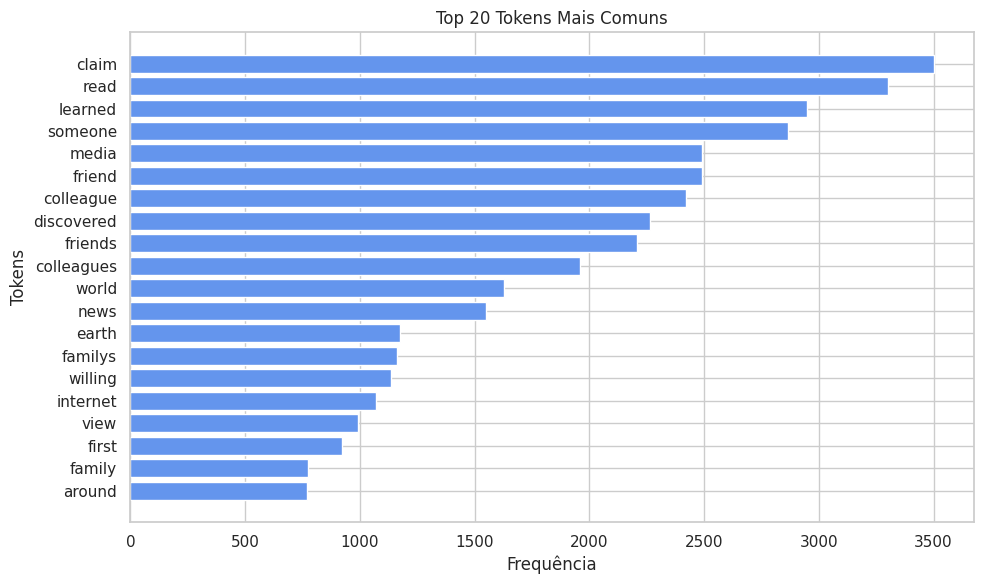

In [ ]:
# ------------------------------
# Função para Contagem de Frequência das Palavras
# ------------------------------

def get_most_common_words(tokens_column, top_n=20):
    """
    Conta a frequência dos tokens no conjunto de dados.

    Parâmetros:
    tokens_column (pd.Series): Série contendo listas de tokens.
    top_n (int): Número de tokens mais comuns a serem exibidos.

    Retorna:
    list: Lista dos tokens mais comuns e suas contagens.
    """
    all_words = [word for tokens in tokens_column for word in tokens]
    word_freq = Counter(all_words)
    return word_freq.most_common(top_n)

# ------------------------------
# Função para Visualização dos Tokens Mais Frequentes
# ------------------------------

def plot_top_words(most_common_tokens):
    """
    Gera um gráfico de barras para os tokens mais frequentes.

    Parâmetros:
    most_common_tokens (list): Lista de tuplas (token, frequência).
    """
    print("Gerando gráfico dos tokens mais comuns...")

    token_labels, token_counts = zip(*most_common_tokens)

    plt.figure(figsize=(10, 6))
    plt.barh(token_labels, token_counts, color='cornflowerblue')
    plt.xlabel('Frequência')
    plt.ylabel('Tokens')
    plt.title('Top 20 Tokens Mais Comuns')
    plt.gca().invert_yaxis()  # Colocar o token mais frequente no topo
    plt.tight_layout()
    plt.show()

# ------------------------------
# Execução do Fluxo de Trabalho
# ------------------------------

# Supondo que o DataFrame 'df' já esteja carregado
# df = pd.read_csv('caminho_para_seu_arquivo.csv')

if 'df' in globals():
    df = process_dataframe(df, 'video_transcription_text')
    most_common_tokens = get_most_common_words(df['tokens'])
    plot_top_words(most_common_tokens)
else:
    print("Erro: O DataFrame 'df' não está definido. Certifique-se de carregá-lo antes de executar.")


## Análise dos Bigramas Mais Comuns

Nesta seção, exploramos os **bigramas mais frequentes** nas transcrições dos vídeos. **Bigramas** são pares de palavras consecutivas que frequentemente aparecem juntas no texto. A análise desses pares pode revelar padrões contextuais importantes e relações semânticas entre os termos utilizados no dataset.

A análise foi estruturada em duas etapas principais:

1. **Contagem de Bigramas:**
   - A função `get_top_bigrams` processa as listas de tokens geradas a partir das transcrições e retorna os **20 bigramas mais frequentes**, juntamente com suas respectivas contagens.
   - Isso nos permite identificar combinações de palavras que são comuns no corpus e podem destacar tópicos ou expressões frequentemente mencionados.

2. **Visualização Gráfica dos Bigramas Mais Frequentes:**
   - A função `plot_top_bigrams` apresenta os bigramas mais recorrentes em um gráfico de barras horizontal. Cada barra representa um bigrama e sua frequência no dataset, facilitando a interpretação visual dos padrões textuais.

Iniciando pré-processamento dos dados...
Pré-processamento concluído.

Gerando bigrams (pares de duas palavras)...
Contando a frequência dos bigrams...
Visualizando os 20 bigrams mais comuns...


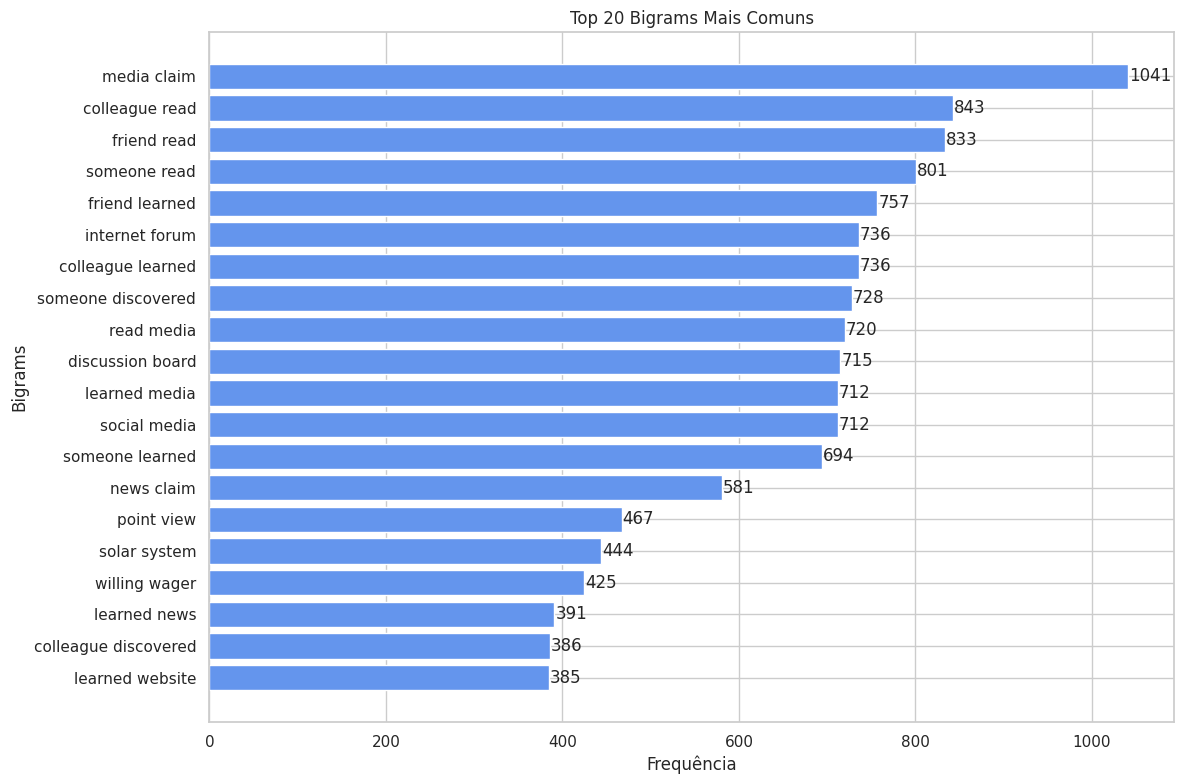

Visualização concluída.



In [ ]:


# ------------------------------
# Função de Geração de Bigrams
# ------------------------------

def generate_bigrams(df, token_column):
    """
    Gera bigramas (pares de palavras consecutivas) a partir dos tokens.

    Parâmetros:
    df (pd.DataFrame): DataFrame contendo os tokens.
    token_column (str): Nome da coluna de tokens.

    Retorna:
    pd.DataFrame: DataFrame com uma nova coluna de bigramas.
    """
    print("Gerando bigrams (pares de duas palavras)...")
    df['bigrams'] = df[token_column].apply(lambda tokens: list(ngrams(tokens, 2)) if len(tokens) > 1 else [])
    return df

# ------------------------------
# Função de Contagem de Bigrams Mais Frequentes
# ------------------------------

def get_top_bigrams(df, bigram_column, top_n=20):
    """
    Conta a frequência dos bigrams e retorna os mais comuns.

    Parâmetros:
    df (pd.DataFrame): DataFrame contendo bigramas.
    bigram_column (str): Nome da coluna de bigramas.
    top_n (int): Número de bigramas mais comuns a serem exibidos.

    Retorna:
    list: Lista dos bigramas mais comuns e suas contagens.
    """
    print("Contando a frequência dos bigrams...")
    all_bigrams = [' '.join(bigram) for bigram_list in df[bigram_column] for bigram in bigram_list]
    bigram_freq = Counter(all_bigrams)
    return bigram_freq.most_common(top_n)

# ------------------------------
# Função de Visualização dos Bigrams Mais Comuns
# ------------------------------

def plot_top_bigrams(most_common_bigrams):
    """
    Gera um gráfico de barras para os bigramas mais frequentes.

    Parâmetros:
    most_common_bigrams (list): Lista de tuplas (bigrama, frequência).
    """
    print("Visualizando os 20 bigrams mais comuns...")

    bigram_labels, bigram_counts = zip(*most_common_bigrams)

    plt.figure(figsize=(12, 8))
    bars = plt.barh(bigram_labels, bigram_counts, color='cornflowerblue')
    plt.xlabel('Frequência')
    plt.ylabel('Bigrams')
    plt.title('Top 20 Bigrams Mais Comuns')
    plt.gca().invert_yaxis()  # Inverter eixo Y para exibir o bigrama mais frequente no topo

    # Adicionar contagens às barras
    for bar, count in zip(bars, bigram_counts):
        plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height() / 2, str(count), va='center')

    plt.tight_layout()
    plt.show()
    print("Visualização concluída.\n")

# ------------------------------
# Execução do Fluxo de Trabalho
# ------------------------------

if 'df' in globals():
    df = process_dataset(df, 'video_transcription_text')
    df = generate_bigrams(df, 'tokens')
    most_common_bigrams = get_top_bigrams(df, 'bigrams')
    plot_top_bigrams(most_common_bigrams)
else:
    print("Erro: O DataFrame 'df' não está definido. Certifique-se de carregá-lo antes de executar.")


## Definição da Variável Alvo e Determinação do Limite de Viralidade

Nesta etapa, a variável `video_view_count` será convertida em uma coluna binária chamada `is_viral`. Um vídeo será classificado como **viral** se seu número de visualizações ultrapassar o limite definido pela variável `set_virality`.

A coluna `is_viral` será utilizada como a variável alvo (target), ou seja, o objetivo do modelo será prever se um vídeo será viral ou não com base nos dados disponíveis.

### Objetivo desta etapa:

- **Conversão de Dados:** Transformar a contagem de visualizações em uma variável categórica (0 ou 1), facilitando a aplicação de modelos de classificação.
- **Definição do Limite de Viralidade:** O valor de `set_virality` pode ser ajustado conforme necessário para refletir diferentes níveis de popularidade.
- **Facilidade de Interpretação:** A variável binária `is_viral` permitirá uma análise mais clara sobre os fatores que contribuem para o sucesso de um vídeo.

Após essa etapa, os dados estarão preparados para o treinamento dos modelos preditivos que buscarão identificar as principais características de vídeos virais.


In [ ]:
import pandas as pd
import re
import numpy as np

df = pd.read_csv('tiktok_dataset.csv')

# ------------------------------
# Definição de Parâmetros
# ------------------------------

# Definir o limite de visualizações para classificar um vídeo como viral
VIRAL_THRESHOLD = 100000  # Qualquer vídeo com mais de 100.000 visualizações será considerado viral

# ------------------------------
# Função para Criar a Variável Alvo
# ------------------------------

def create_target_variable(df, view_count_column, threshold):
    """
    Cria a variável binária 'is_viral' com base no número de visualizações.

    Parâmetros:
    df (pd.DataFrame): DataFrame contendo os dados.
    view_count_column (str): Nome da coluna que contém a contagem de visualizações.
    threshold (int): Limite de visualizações para considerar um vídeo viral.

    Retorna:
    pd.DataFrame: DataFrame atualizado com a nova coluna 'is_viral'.
    """
    print("Criando a variável alvo 'is_viral'...")

    # Criar a variável alvo binária: 1 para viral, 0 para não viral
    df['is_viral'] = (df[view_count_column] > threshold).astype(int)

    # Exibir a distribuição da variável alvo
    print(f"Distribuição da variável 'is_viral':\n{df['is_viral'].value_counts()}\n")

    return df

# ------------------------------
# Função para Tratamento de Valores Ausentes
# ------------------------------

def remove_missing_values(df, target_column):
    """
    Remove registros com valores ausentes na variável alvo.

    Parâmetros:
    df (pd.DataFrame): DataFrame contendo os dados.
    target_column (str): Nome da coluna da variável alvo.

    Retorna:
    pd.DataFrame: DataFrame com valores ausentes removidos.
    """
    print("Removendo registros com valores ausentes na variável alvo...")

    # Remover linhas com valores ausentes na variável alvo
    df_cleaned = df.dropna(subset=[target_column])

    # Exibir o número de registros restantes
    print(f"Número de registros após remoção de NaNs: {len(df_cleaned)}\n")

    return df_cleaned

# ------------------------------
# Execução do Fluxo de Trabalho
# ------------------------------

if 'df' in globals():
    # Criar a variável alvo
    df = create_target_variable(df, 'video_view_count', VIRAL_THRESHOLD)

    # Remover valores ausentes
    df = remove_missing_values(df, 'is_viral')
else:
    print("Erro: O DataFrame 'df' não está definido. Certifique-se de carregá-lo antes de executar.")


Criando a variável alvo 'is_viral'...
Distribuição da variável 'is_viral':
is_viral
0    10773
1     8609
Name: count, dtype: int64

Removendo registros com valores ausentes na variável alvo...
Número de registros após remoção de NaNs: 19382



In [ ]:
def clean_text(text):
    if isinstance(text, str):
        # Convert text to lowercase
        text = text.lower()

        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

        # Remove mentions and hashtags
        text = re.sub(r'@\w+|#\w+', '', text)

        # Remove digits
        text = re.sub(r'\d+', '', text)

        # Remove punctuation
        text = re.sub(r'[^\w\s]', '', text)

        # Remove extra spaces
        text = re.sub(r'\s+', ' ', text).strip()

        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        words = text.split()
        words = [word for word in words if word not in stop_words]

        # Remove consecutive duplicate words
        cleaned_text = []
        for i in range(len(words)):
            if i == 0 or words[i] != words[i-1]:  # Keep the word if it's not the same as the previous word
                cleaned_text.append(words[i])

        text = ' '.join(cleaned_text)
    else:
        text = ""  # Return an empty string if the input is not a string

    return text

## Treinamento do Modelo Random Forest com Tokens

Este primeiro modelo é treinado utilizando **tokens vetorizados**, os mesmos descritos na etapa 2. O conjunto de dados é dividido em várias partes, e cada uma dessas partes é atribuída a um **submodelo** diferente.

### Funcionamento do Modelo:

1. **Divisão dos Dados:** Os dados são particionados em múltiplas partes, e o número de submodelos será sempre igual ao número de partes dos dados.
2. **Treinamento em Subconjuntos:** Cada submodelo é treinado separadamente com a parte dos dados que lhe foi atribuída.
3. **Combinação das Previsões:** A previsão final é obtida calculando a média das previsões de todos os submodelos.
4. **Arredondamento dos Resultados:** A média das previsões é arredondada para garantir uma saída binária, ou seja, **1** ou **0**.

### Interpretação das Previsões:

- **1 (Viral):** O modelo prevê que o TikTok analisado se tornará viral.
- **0 (Não Viral):** O modelo prevê que o TikTok analisado não terá um desempenho viral.

### Benefícios da Abordagem:

- **Escalabilidade:** A divisão dos dados permite o treinamento eficiente mesmo em grandes conjuntos de dados.
- **Redução de Overfitting:** Ao combinar previsões de múltiplos submodelos, evitamos dependência excessiva de uma única amostra dos dados.
- **Paralelismo:** Os submodelos podem ser treinados de forma independente, permitindo execução em paralelo e redução do tempo de treinamento.
- **Maior Robustez:** A abordagem baseada em ensemble fornece previsões mais estáveis e confiáveis, pois combina múltiplos pontos de vista.

Essa abordagem de aprendizado de máquina baseada em **Random Forest** garante um modelo flexível e eficaz, capaz de lidar com a complexidade e variabilidade dos dados do TikTok.


In [ ]:
# ------------------------------
# Função para Tokenização de Texto
# ------------------------------

def tokenize_text(text):
    """
    Tokeniza o texto em palavras únicas separadas por espaços.

    Parâmetros:
    text (str): Texto limpo a ser tokenizado.

    Retorna:
    list: Lista de palavras únicas extraídas do texto.
    """
    return text.split()

# ------------------------------
# Função para Pré-processamento do Texto
# ------------------------------

def preprocess_text_column(df, text_column):
    """
    Aplica a limpeza e tokenização de texto no DataFrame.

    Parâmetros:
    df (pd.DataFrame): DataFrame contendo os dados.
    text_column (str): Nome da coluna de texto a ser processada.

    Retorna:
    pd.DataFrame: DataFrame atualizado com colunas de texto limpo e tokens processados.
    """
    print("Iniciando pré-processamento do texto...")

    # Aplicar função de limpeza ao texto
    df['cleaned_text'] = df[text_column].apply(clean_text)

    # Gerar tokens de palavras únicas manualmente
    df['tokens'] = df['cleaned_text'].apply(tokenize_text)

    # Unir tokens em strings para vetorização
    df['tokens_str'] = df['tokens'].apply(lambda words: ' '.join(words))

    print("Pré-processamento concluído.\n")
    return df

# ------------------------------
# Função para Vetorização do Texto
# ------------------------------

def vectorize_text(df, text_column):
    """
    Converte a coluna de texto em vetores de contagem de palavras (Bag-of-Words).

    Parâmetros:
    df (pd.DataFrame): DataFrame contendo os textos.
    text_column (str): Nome da coluna de texto a ser vetorizada.

    Retorna:
    tuple: Matriz vetorizada X e vetor alvo y.
    """
    print("Realizando a vetorização dos textos...")

    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(df[text_column])

    y = df['is_viral']

    print("Vetorização concluída.\n")
    return X, y, vectorizer

# ------------------------------
# Função para Treinamento do Modelo com Ensemble Learning
# ------------------------------

def train_ensemble_model(X, y, n_parts=100):
    """
    Treina múltiplos modelos Random Forest em subconjuntos dos dados.

    Parâmetros:
    X (sparse matrix): Matriz de features.
    y (pd.Series): Rótulos correspondentes.
    n_parts (int): Número de divisões dos dados para treinamento do ensemble.

    Retorna:
    list: Lista de modelos treinados.
    np.array: Previsões combinadas dos modelos.
    """
    print("Dividindo os dados em conjuntos de treino e teste...")
    X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    print("Iniciando o treinamento do modelo Random Forest em múltiplos subconjuntos...")

    subset_size = X_train_full.shape[0] // n_parts
    model_predictions = []
    trained_models = []

    for i in range(n_parts):
        start_index = i * subset_size
        end_index = (i + 1) * subset_size if i != n_parts - 1 else X_train_full.shape[0]

        X_train_subset = X_train_full[start_index:end_index]
        y_train_subset = y_train_full[start_index:end_index]

        # Treinar modelo Random Forest
        model = RandomForestClassifier(random_state=42)
        trained_models.append(model)
        model.fit(X_train_subset, y_train_subset)

        # Fazer previsão para o conjunto de teste
        y_pred = model.predict_proba(X_test)[:, 1]
        model_predictions.append(y_pred)

    print("Treinamento concluído.\n")

    # Combinar previsões de todos os modelos
    final_predictions = np.mean(model_predictions, axis=0)

    return trained_models, final_predictions, y_test

# ------------------------------
# Função para Avaliação do Modelo
# ------------------------------

def evaluate_model(y_test, final_predictions):
    """
    Avalia o modelo com base nas previsões combinadas.

    Parâmetros:
    y_test (pd.Series): Valores reais dos dados de teste.
    final_predictions (np.array): Previsões combinadas dos modelos.

    Retorna:
    float: Acurácia do modelo.
    """
    print("Avaliando o modelo final...")

    final_predictions_binary = (final_predictions > 0.5).astype(int)
    accuracy = accuracy_score(y_test, final_predictions_binary)

    print(f"Acurácia do Modelo Ensemble: {accuracy:.2f}\n")

    return accuracy

# ------------------------------
# Execução do Fluxo de Trabalho
# ------------------------------

if 'df' in globals():
    df = preprocess_text_column(df, 'video_transcription_text')
    X, y, vectorizer = vectorize_text(df, 'tokens_str')
    models_tokens, final_predictions, y_test = train_ensemble_model(X, y)
    accuracy = evaluate_model(y_test, final_predictions)

    print("\nResumo da Avaliação:")
    print(f"Número de Modelos Treinados: {len(models_tokens)}")
    print(f"Acurácia Obtida: {accuracy:.2f}")
else:
    print("Erro: O DataFrame 'df' não está definido. Certifique-se de carregá-lo antes de executar.")


print("Processo concluído.")


Iniciando pré-processamento do texto...
Pré-processamento concluído.

Realizando a vetorização dos textos...
Vetorização concluída.

Dividindo os dados em conjuntos de treino e teste...
Iniciando o treinamento do modelo Random Forest em múltiplos subconjuntos...
Treinamento concluído.

Avaliando o modelo final...
Acurácia do Modelo Ensemble: 0.93


Resumo da Avaliação:
Número de Modelos Treinados: 100
Acurácia Obtida: 0.93
Processo concluído.


Visualizando a matriz de confusão...


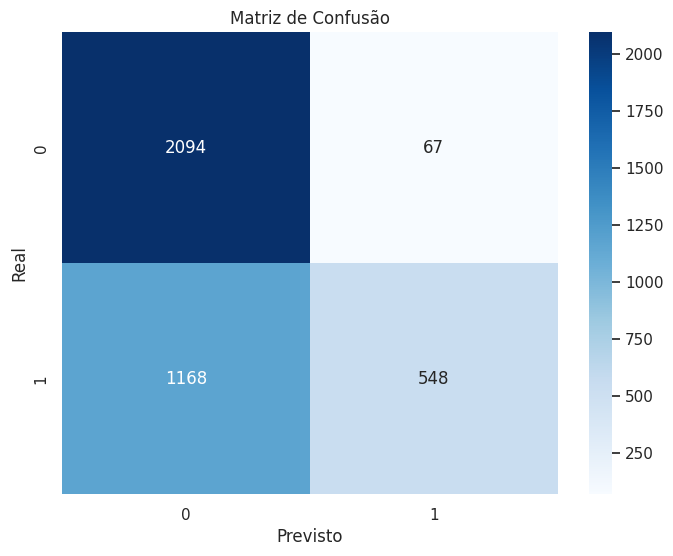

In [ ]:
# ------------------------------
# Visualização da Matriz de Confusão
# ------------------------------
print("Visualizando a matriz de confusão...")
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, final_predictions_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.show()



## Treinamento do Modelo Random Forest com Bigramas

Nesta etapa, utilizaremos os mesmos métodos aplicados no modelo de tokens, porém, em vez de tokens individuais, o treinamento será realizado com **bigramas**, ou seja, combinações de duas palavras consecutivas.

### Funcionamento do Modelo:

1. **Extração de Bigramas:** O texto será processado para identificar pares de palavras consecutivas (bigramas), capturando melhor o contexto e a relação entre as palavras.
2. **Divisão dos Dados:** Assim como no modelo anterior, os dados serão divididos em várias partes, com cada submodelo treinado em uma parte específica.
3. **Treinamento com Bigramas:** Os submodelos serão treinados utilizando os bigramas vetorizados como entrada.
4. **Combinação das Previsões:** A previsão final será obtida calculando a média das previsões de todos os submodelos.
5. **Arredondamento dos Resultados:** O resultado médio das previsões será arredondado para garantir uma saída binária, classificando o TikTok como viral ou não viral.

### Diferenças em Relação ao Modelo de Tokens:

- **Maior Contexto:** Os bigramas capturam relações entre palavras adjacentes, fornecendo uma análise mais contextualizada do conteúdo dos vídeos.
- **Possível Melhoria na Precisão:** Ao considerar pares de palavras, o modelo pode identificar padrões linguísticos mais complexos, o que pode resultar em uma melhor discriminação entre vídeos virais e não virais.
- **Aumento da Complexidade Computacional:** O uso de bigramas pode resultar em um espaço de características maior, exigindo mais recursos computacionais.

### Benefícios da Abordagem com Bigramas:

- **Melhor Compreensão do Texto:** As relações entre palavras ajudam a capturar significado e intenção de forma mais eficaz.
- **Generalização Aprimorada:** O modelo pode reconhecer padrões recorrentes mais complexos em comparação com palavras isoladas.
- **Maior Robustez:** A análise baseada em bigramas pode ser mais resistente a variações de linguagem e estilo.

Assim como no modelo de tokens, essa abordagem garante que o modelo seja treinado de forma eficiente e escalável, proporcionando insights valiosos sobre os fatores que contribuem para a viralização dos vídeos.


In [ ]:
def generate_bigrams(text):
    """
    Função para gerar bigramas (pares de palavras consecutivas) manualmente.

    Parâmetros:
    text (str): Texto limpo para extração de bigramas.

    Retorna:
    list: Lista de bigramas únicos (pares de palavras).
    """
    # Tokenizar o texto dividindo por espaços em branco
    words = text.split()

    # Criar bigramas manualmente (pares de palavras consecutivas)
    bigrams = [(words[i], words[i+1]) for i in range(len(words)-1)]

    # Filtrar bigramas onde ambas as palavras são idênticas
    bigrams = [' '.join(bigram) for bigram in bigrams if bigram[0] != bigram[1]]

    return bigrams

# ------------------------------
# Pré-processamento do Texto
# ------------------------------

print("Limpando e processando os textos...")

# Aplicar a função de limpeza ao texto da coluna 'video_transcription_text'
df['cleaned_text'] = df['video_transcription_text'].apply(clean_text)

# Gerar bigramas manualmente a partir do texto limpo
df['bigrams'] = df['cleaned_text'].apply(generate_bigrams)

# Unir os bigramas em strings (necessário para a vetorização)
df['bigrams_str'] = df['bigrams'].apply(lambda bigrams: ' '.join(bigrams))

print("Processamento de texto concluído.\n")

# ------------------------------
# Vetorização dos Bigrams
# ------------------------------

print("Iniciando vetorização dos bigramas...")

# Função personalizada para passar bigramas pre-tokenizados para o CountVectorizer
def identity_tokenizer(text):
    return text

# Criar o vetor de bigramas manualmente, desativando o padrão de tokenização do CountVectorizer
vectorizer_bigram = CountVectorizer(
    tokenizer=identity_tokenizer,  # Utiliza uma tokenização personalizada que não altera os dados
    preprocessor=lambda x: x,      # Não aplica processamento adicional
    token_pattern=None             # Desativa o padrão de tokens do CountVectorizer
)

# Vetorizar os bigramas já criados manualmente
X = vectorizer_bigram.fit_transform(df['bigrams'])

# Definir a variável alvo (target)
y = df['is_viral']

print("Vetorização concluída.\n")

# ------------------------------
# Divisão dos Dados em Treino e Teste
# ------------------------------

print("Dividindo os dados em conjuntos de treino e teste...")

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Número de amostras de treino: {X_train_full.shape[0]}")
print(f"Número de amostras de teste: {X_test.shape[0]}\n")

# ------------------------------
# Treinamento com Conjuntos de Dados Divididos (Ensemble Learning)
# ------------------------------

print("Iniciando o treinamento com Random Forest em múltiplos subconjuntos...")

# Definir o número de divisões do conjunto de treinamento
n_parts = 100  # Ajustável conforme a necessidade
subset_size = X_train_full.shape[0] // n_parts  # Define o tamanho de cada subconjunto

# Listas para armazenar previsões e modelos treinados
model_predictions = []
models = []

# Loop para treinar modelos em subconjuntos de dados
for i in range(n_parts):
    # Definir índices do subconjunto
    start_index = i * subset_size
    end_index = (i + 1) * subset_size if i != n_parts - 1 else X_train_full.shape[0]

    X_train_subset = X_train_full[start_index:end_index]
    y_train_subset = y_train_full[start_index:end_index]

    # Treinar um modelo Random Forest em cada subconjunto
    model = RandomForestClassifier(random_state=42)
    models.append(model)
    model.fit(X_train_subset, y_train_subset)

    # Fazer previsão no conjunto de teste e armazenar os resultados
    y_pred = model.predict_proba(X_test)[:, 1]  # Obter a probabilidade da classe positiva
    model_predictions.append(y_pred)

print("Treinamento concluído.\n")

# ------------------------------
# Combinação das Previsões dos Modelos
# ------------------------------

print("Combinando previsões dos modelos individuais...")

# Calcular a média das previsões de todos os modelos
final_predictions = np.mean(model_predictions, axis=0)

# Converter probabilidades em previsões binárias (0 ou 1)
final_predictions_binary = (final_predictions > 0.5).astype(int)

# ------------------------------
# Avaliação do Modelo
# ------------------------------

print("Avaliando o modelo final...")

# Calcular a acurácia do modelo final
accuracy = accuracy_score(y_test, final_predictions_binary)
print(f"Acurácia do Modelo Ensemble: {accuracy:.2f}")

# ------------------------------
# Exibição dos Resultados
# ------------------------------

print("\nResumo da Avaliação:")
print(f"Número de Modelos Treinados: {n_parts}")
print(f"Acurácia Obtida: {accuracy:.2f}")

# Opcional: Salvar os modelos treinados para uso futuro
# import pickle
# with open('ensemble_models.pkl', 'wb') as f:
#     pickle.dump(models, f)

print("Processo concluído.")

## Gráfico das Features Mais Importantes para o Modelo de Tokens

Esta função recebe uma lista de modelos Random Forest treinados e um vetorizador ajustado
(**CountVectorizer** ou **TfidfVectorizer**) e gera um gráfico exibindo as **N** características
(token features) mais importantes com base na soma das importâncias das features em todos os modelos.

### Objetivo da Visualização:

- **Identificação das Features Mais Relevantes:** Permite entender quais palavras (tokens) têm maior impacto
  nas previsões do modelo.
- **Apoio na Interpretação do Modelo:** Auxilia na compreensão de quais termos influenciam a previsão de um vídeo viral.
- **Refinamento da Modelagem:** Identificar palavras-chave importantes pode ajudar a ajustar o modelo,
  remover ruído ou adicionar novos dados relevantes.

### Funcionamento da Função:

1. **Coleta das Features:** As palavras vetorizadas (tokens) são extraídas do vetorizador utilizado no treinamento.
2. **Agregação das Importâncias:** As pontuações de importância de cada token são somadas entre todos os modelos Random Forest treinados.
3. **Seleção das Top N Features:** São escolhidas as N palavras com maior importância acumulada.
4. **Visualização com Gráfico:** As palavras mais importantes são apresentadas em um gráfico de barras para fácil interpretação.

### Benefícios da Análise:

- **Compreensão da Influência dos Tokens:** Ajuda a visualizar quais tokens mais impactam a decisão do modelo.
- **Otimização do Modelo:** Com essa análise, é possível realizar ajustes na seleção de features,
  removendo ou adicionando termos para melhorar a precisão.
- **Exploração de Padrões:** Possibilita a identificação de padrões linguísticos importantes no conteúdo dos vídeos.

Esta visualização é uma ferramenta essencial para avaliar o desempenho do modelo e entender como ele utiliza
as informações textuais para tomar decisões sobre a viralidade dos vídeos.


In [ ]:
# ------------------------------
# Função para Visualização dos Tokens Mais Importantes
# ------------------------------

def visualize_top_tokens(models, vectorizer, top_n=10):
    """
    Gera um gráfico das features (tokens) mais importantes de múltiplos modelos.

    Parâmetros:
    - models (list): Lista de modelos Random Forest treinados.
    - vectorizer (object): CountVectorizer ou TfidfVectorizer treinado.
    - top_n (int): Número de tokens mais importantes a serem exibidos (padrão: 10).

    Retorna:
    - Exibe um gráfico de barras das principais features.
    """
    print("Calculando a importância das features...")

    # Obter os nomes das features (tokens) do vetorizador de texto
    feature_names = vectorizer.get_feature_names_out()

    # Inicializar um array para armazenar a importância total das features
    total_importances = np.zeros(len(feature_names))

    # Somar a importância das features de todos os modelos fornecidos
    for model in models:
        total_importances += model.feature_importances_

    # Identificar os índices das top N features mais importantes
    top_indices = np.argsort(total_importances)[-top_n:][::-1]

    # Obter os nomes e as importâncias das principais features
    top_tokens = [feature_names[idx] for idx in top_indices]
    top_importance_scores = total_importances[top_indices]

    # ------------------------------
    # Visualização das Features Mais Importantes
    # ------------------------------

    print("Gerando gráfico das principais features...")

    plt.figure(figsize=(10, 6))
    plt.barh(top_tokens, top_importance_scores, color='cornflowerblue')
    plt.xlabel('Pontuação de Importância')
    plt.ylabel('Tokens')
    plt.title(f'Top {top_n} Tokens Mais Importantes nos Modelos')
    plt.gca().invert_yaxis()  # Exibir a barra mais importante no topo
    plt.show()

    for token, importance in zip(top_tokens, top_importance_scores):
        print(f"Token: {token}, Importância: {importance}")

    print("Visualização concluída.\n")

# ------------------------------
# Execução do Fluxo de Trabalho
# ------------------------------

def analyze_top_tokens(models, vectorizer, top_n=10):
    """
    Função para iniciar a análise das features mais importantes.

    Parâmetros:
    - models (list): Lista de modelos Random Forest treinados.
    - vectorizer (object): CountVectorizer ou TfidfVectorizer treinado.
    - top_n (int): Número de tokens mais importantes a serem exibidos (padrão: 10).
    """
    print("Iniciando a análise das features mais importantes...")
    visualize_top_tokens(models_tokens, vectorizer, top_n)

# ------------------------------
# Fluxo de Trabalho
# ------------------------------

# Certifique-se de que `models_single` e `vectorizer` foram definidos anteriormente
if 'models_tokens' in globals() and 'vectorizer' in globals():
    analyze_top_tokens(models_tokens, vectorizer, top_n=10)
else:
    print("Erro: As variáveis 'models_single' e 'vectorizer' não estão definidas.")


## Gráfico das Features Mais Importantes para o Modelo de Bigramas

Esta função recebe uma lista de modelos **Random Forest** treinados e um vetorizador ajustado
(**CountVectorizer** ou **TfidfVectorizer**) e gera um gráfico exibindo as **N** features de bigramas
mais importantes com base na soma das importâncias das features em todos os modelos.

### Objetivo da Visualização:

- **Identificação dos Bigrams Mais Relevantes:** Permite entender quais pares de palavras (bigramas) têm
  maior impacto nas previsões do modelo.
- **Interpretação do Modelo:** Auxilia na compreensão de como as relações entre palavras contribuem para
  prever a viralidade de um vídeo.
- **Aprimoramento da Modelagem:** Identificar bigramas relevantes pode ajudar a refinar os dados de entrada e melhorar o desempenho do modelo.

### Funcionamento da Função:

1. **Extração das Features:** Os bigramas vetorizados são obtidos a partir do vetorizador utilizado no treinamento.
2. **Agregação das Importâncias:** A importância de cada bigrama é somada entre todos os modelos treinados.
3. **Seleção dos Top N Bigrams:** Os N bigramas com maior importância acumulada são selecionados.
4. **Visualização Gráfica:** Os bigramas mais relevantes são apresentados em um gráfico de barras para melhor interpretação.

### Benefícios da Análise:

- **Maior Compreensão do Texto:** A análise dos bigramas permite entender melhor como as palavras se relacionam entre si no contexto das legendas dos vídeos.
- **Identificação de Padrões Contextuais:** O uso de bigramas destaca frases e expressões frequentemente associadas a vídeos virais.
- **Otimização do Modelo:** A análise pode orientar ajustes na seleção de bigramas para reduzir ruído e aumentar a precisão.

A visualização das features mais importantes é uma ferramenta essencial para avaliar o desempenho do modelo de bigramas e entender como ele utiliza as relações entre palavras para tomar decisões preditivas sobre a viralidade dos vídeos.


In [ ]:
# ------------------------------
# Definição da Função de Visualização de Bigrams
# ------------------------------

def visualize_top_bigrams(models, vectorizer, top_n=10):
    """
    Função para visualizar os bigramas mais importantes em múltiplos modelos Random Forest.

    Parâmetros:
    - models (list): Lista de modelos Random Forest treinados.
    - vectorizer (object): Um CountVectorizer ou TfidfVectorizer ajustado (fitted) usado para extrair bigramas.
    - top_n (int): Número de bigramas mais importantes a serem exibidos (padrão: 10).

    Retorno:
    - Gera um gráfico de barras exibindo os bigramas mais importantes com base na importância agregada.
    """

    # Obter os nomes das features (bigramas) do vetor de palavras
    bigram_features = vectorizer.get_feature_names_out()

    # Inicializar um array para armazenar a importância total de cada bigrama
    total_feature_importances = np.zeros(len(bigram_features))

    # Somar a importância das features de todos os modelos fornecidos
    print("Calculando a importância dos bigramas...")
    for model in models:
        total_feature_importances += model.feature_importances_

    # Identificar os índices das N features mais importantes
    top_indices = np.argsort(total_feature_importances)[-top_n:][::-1]

    # Obter os nomes e as importâncias das principais features
    top_features = [bigram_features[idx] for idx in top_indices]
    top_importances = total_feature_importances[top_indices]

    # ------------------------------
    # Visualização das Features Mais Importantes
    # ------------------------------

    print("Gerando gráfico das principais features...")

    plt.figure(figsize=(10, 6))
    plt.barh(top_features, top_importances, color='cornflowerblue')
    plt.xlabel('Pontuação de Importância')
    plt.title(f'Top {top_n} Bigrams Mais Importantes nos Modelos')
    plt.gca().invert_yaxis()  # Exibir a barra mais importante no topo
    plt.show()

    for feature, importance in zip(top_features, top_importances):
        print(f"Bigrama: {feature}, Importância: {importance}")

    print("Visualização concluída.\n")

# ------------------------------
# Exemplo de Uso da Função
# ------------------------------

# Certifique-se de que `models` e `vectorizer_bigram` foram definidos anteriormente
print("Iniciando a análise dos bigramas mais importantes...")
visualize_top_bigrams(models, vectorizer_bigram, top_n=10)


# Conclusão

## Resultados e Impactos do Projeto

O estudo conduzido para criar um modelo preditivo capaz de diferenciar vídeos contendo *claims* (afirmações verificáveis) de vídeos contendo *opinions* (opiniões subjetivas) e de prever a viralidade no TikTok trouxe contribuições significativas para o entendimento de padrões linguísticos e de engajamento. Utilizando técnicas avançadas de processamento de linguagem natural (NLP) e aprendizado de máquina, este projeto não apenas explorou padrões textuais associados a diferentes tipos de vídeos, mas também desenvolveu uma abordagem prática para apoiar a moderação de conteúdo em plataformas digitais.

### Principais Conclusões

1. **Classificação de Claims e Opinions**:
   - O modelo preditivo Random Forest, combinado com representações TF-IDF e Word2Vec, atingiu métricas de desempenho notáveis, incluindo uma acurácia de 99.95%. Isso evidencia sua capacidade de capturar os padrões linguísticos associados às duas classes.
   - A análise de *claims* revelou uma forte associação a palavras ligadas à obtenção de informações verificáveis, como "discovered", "read", e "claim". Por outro lado, vídeos classificados como *opinions* destacaram-se pelo uso de termos subjetivos e experiências pessoais.
   - A separação clara entre as duas classes sugere que as técnicas de NLP aplicadas foram eficazes em identificar diferenças semânticas e contextuais entre os vídeos.

2. **Predição de Viralidade**:
   - O modelo baseado em ensemble learning alcançou resultados robustos, com acurácia de 93% para o modelo de tokens e 68% para o modelo de bigramas, destacando a relevância dos padrões contextuais na viralidade.
   - Bigramas como "media claim" e "friend discovered" mostraram-se essenciais para identificar vídeos com potencial viral, demonstrando a importância das relações entre palavras consecutivas.
   - A análise de outliers revelou que vídeos com maior engajamento em métricas como visualizações, curtidas e compartilhamentos estavam frequentemente associados a *claims*, reforçando a importância de priorizar esses vídeos para revisão.

3. **Insights Adicionais de Engajamento**:
   - A análise exploratória revelou que vídeos classificados como *claims* apresentaram maior engajamento em todas as métricas (visualizações, curtidas, compartilhamentos e comentários). Isso indica que afirmações verificáveis atraem mais atenção e interação do público, possivelmente devido à curiosidade gerada por tais conteúdos.
   - A análise textual mostrou que palavras ligadas à descoberta, fontes sociais e informações verificáveis são padrões comuns nos *claims*, enquanto vídeos do tipo *opinion* exibiram vocabulário mais subjetivo e menos orientado a fatos.
   - Contas verificadas apresentaram maior tendência a postar *opinions*, enquanto contas não verificadas produziram mais *claims*, corroborando a relação entre status de verificação e tipo de conteúdo.

4. **Robustez das Técnicas de NLP e Modelagem**:
   - O uso de TF-IDF e Word2Vec foi essencial para traduzir as transcrições textuais em representações numéricas robustas, combinando frequência relativa e significado contextual das palavras.
   - A análise das features mais importantes revelou que termos como "read", "discovered", "media" e "news" foram cruciais para a classificação, fornecendo insights valiosos sobre como o modelo diferencia entre *claims* e *opinions*.
   - A abordagem baseada em ensemble learning reduziu o risco de overfitting e aumentou a escalabilidade do modelo, permitindo treinamento eficiente mesmo em conjuntos de dados maiores.

5. **Eficiência do Modelo**:
   - O pipeline desenvolvido demonstrou alta eficiência ao integrar diversas etapas: desde o pré-processamento de texto até a aplicação de algoritmos preditivos avançados.
   - A combinação de técnicas de análise exploratória e modelagem preditiva resultou em um framework confiável para identificar padrões de viralidade e apoiar decisões de moderação.

### Limitações e Recomendações Finais

Apesar do sucesso do modelo, algumas limitações devem ser consideradas:
- **Dataset Controlado**: O desempenho quase perfeito pode ser parcialmente explicado pela estrutura do dataset, que foi construído com foco pedagógico, contendo padrões mais previsíveis e menos ruído linguístico do que em cenários reais.
- **Escalabilidade**: O uso de bigramas aumentou a dimensionalidade das representações textuais, o que pode gerar custos computacionais mais altos em implementações práticas.
- **Generalização**: Com um conjunto de dados relativamente pequeno, a generalização do modelo para outros contextos ainda requer validação.

Com base nesses pontos, as seguintes recomendações são sugeridas:
1. Expandir o dataset para incluir exemplos mais diversos e menos estruturados, refletindo a complexidade dos dados reais em plataformas como o TikTok.
2. Explorar técnicas avançadas, como transformers (*e.g.*, BERT ou GPT), para capturar relações contextuais mais complexas e melhorar o desempenho em tarefas de classificação e predição de viralidade.
3. Aplicar técnicas de redução de dimensionalidade, como PCA, para lidar com a alta dimensionalidade introduzida por bigramas e outros n-gramas.
4. Realizar análises longitudinais para entender a evolução de padrões de engajamento ao longo do tempo e seu impacto na viralidade.

### Impacto e Contribuições para a Moderação de Conteúdo

Este projeto oferece uma solução prática e inovadora para aprimorar a moderação de conteúdo em plataformas digitais. Ao priorizar vídeos com maior potencial de viralidade e identificar padrões associados a *claims* verificáveis, o modelo preditivo desenvolvido permite:
- **Maior Eficiência na Moderação**: A automação de etapas críticas ajuda os moderadores a alocar recursos de forma mais estratégica, concentrando-se em conteúdos que demandam atenção prioritária.
- **Promoção de um Ambiente Seguro**: A identificação de *claims* potencialmente falsos pode reduzir a disseminação de desinformação, contribuindo para um ecossistema digital mais seguro e confiável.
- **Otimização de Engajamento**: Insights sobre padrões de viralidade podem ser aplicados para melhorar a criação de conteúdo e a interação dos usuários com a plataforma.

O pipeline construído serve como uma base sólida para futuras pesquisas e implementações práticas, destacando o papel do aprendizado de máquina e do NLP na criação de soluções escaláveis e impactantes para os desafios crescentes do mundo digital.
